# Data Mining
## ver 3.3
ver 3.1   
1、修正了自定义的加权平均函数，原权值顺序反了  
2、修正了滚动统计函数，原函数的将mood值的日期+1赋给滚动统计日期的mood值，应为-1  
3、修改了datapreprocess1st函数使用pivot_table代替pivot,可自动聚合，去掉了groupby处理   
ver 3.2   
1、验证了按日合计正确性，与github代码数据一致，不一致为activatiy为score，采用了求平均值，将call、sms统计方式由max修改为sum   
2、自定义函数经验证使用自定义的加权平均函数计算结果正确，可以使用，通过手工计算验证正确   
3、参照github增加了直方图、曲线图绘制  
4、增加了线性插值补齐数据，和绘图   
5、增加了数据列合并删除，github的程序对office和finance合并感觉并不合理，other和unknown合并到other，game和entertainment合并到entertainmen，social和communication合并到social，utilities和weather合并到tools,call和sms合并到call，根据文献circumplex.arousal、circumplex.valence和相关性，circumplex.valence对mood的影响较大，而circumplex.arousal较弱，所以删除circumplex.arousal较弱
6、写了决策树回归，不太明白，score的得分为负值？ 
ver 3.3
1、增加了数据平稳性检验   
2、增加了数据自相关性检验   
3、增加了AMIMA模型   
4、增加了VAR模型   
目前数据处理部分、时间序列模型（AMIMA、VAR）基本完成

In [33]:
"""
@author Group 17-Yunshan Wang(1721621@student.vu.nl 1721621)
@Create 09-04-2022
Data Proprocess
"""
#-*- coding:utf-8 -*-
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

%matplotlib inline

def readcsvfile(csvfilename):
    '''
    读取csv文件，返回dataframe
    
    Args:
        csvfilename: 含路径的csv文件名
        
    Returns:
        读取的dataframe
    '''
    if os.path.exists(csvfilename):
        return pd.read_csv(csvfilename)
    else:
        print('Error:The file {} does not exist!'.format(csvfilename))

path = "E:\\pythonprj\\datamining\\"
filename = 'dataset_mood_smartphone.csv'
df=readcsvfile(path+filename) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376912 entries, 0 to 376911
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  376912 non-null  int64  
 1   id          376912 non-null  object 
 2   time        376912 non-null  object 
 3   variable    376912 non-null  object 
 4   value       376710 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 14.4+ MB


## Exploratory Data Analysis
### 1. 初步数据预处理
数据集：376912行x5列 数据集处理后：358922行x21列   
具体处理见函数为datapreprocess1st   
1) 列处理：通过查看数据描述和统计,第一列Unnamed为序号时无意义列，删除该列，time列为object类型，转换为时间类型  
2）NaN数据处理：数据共376912行，id,time,variable均NaN，而value有37670行非空，删除202行NaN值行  
3）不合理数据处理：activity(number between 0 and 1),appCat.builtin、appCat.entertainment等使用时间数据不能未负值，删除负值  
4）不合理数据处理：相同'id','time','variable'数据，'value'不同，通过求平均值合并   
5）数据转换：将'variable'，'value'转换为列  
6) (可不处理）异常值处理：通过观察df.describe(),发现最大值与Q3(75%值）差异较大，从hist图中可以看到数据分布异常，见表1和图1，对其进行处理，替换为Q3+1.5xIQR后，见表2和图2 


In [34]:
def removeoutliers(df,cols,mode=0):
    '''
    异常值处理
    Args:
        df      ：需处理的dataframe
        cols    ：需处理的列        
        mode    ：process mode，1：NaN，2：mean，3: 75th percentiles，4: 50th percentiles 
    Returns:
        处理后的dataframe
    '''
    dfdesb=df.describe()[cols]
    if mode==1:
        values=pd.Series(np.nan,index=cols)
    elif mode==2:
        values=dfdesb.loc['mean']
    elif mode==3:
        values=dfdesb.loc['75%']
    elif mode==4:
        values=dfdesb.loc['50%']
    else :     
        for col in cols:
            #  reeplace with Q3+1.5xIQR when data > Q3+1.5xIQR 
            df.loc[df[col] > dfdesb[col]['75%']+1.5*(dfdesb[col]['75%']-dfdesb[col]['25%']),col] = dfdesb[col]['75%'] + 1.5*(dfdesb[col]['75%']-dfdesb[col]['25%'])
            #  reeplace with Q1-1.5xIQR when data < Q1-1.5xIQR 
            #tmp.loc[tmp[col] < dfdesb[col]['25%']-1.5*(dfdesb[col]['75%']-dfdesb[col]['25%']),col] = dfdesb[col]['25%'] - 1.5*(dfdesb[col]['75%']-dfdesb[col]['25%'])
        return df
    
    for col in cols:
        #  reeplace with values when data > Q3+1.5xIQR or data <Q1-1.5xIQR
        df.loc[df[col] > dfdesb[col]['75%'] + 1.5*(dfdesb[col]['75%']-dfdesb[col]['25%']),col]= values[col]
        #tmp.loc[tmp[col] < dfdesb[col]['25%'] - 1.5*(dfdesb[col]['75%']-dfdesb[col]['25%']),col]= values[col]
    return df
                     
def datapreprocess1st(df):
    '''
    数据预处理转换时间戳，删除无效列、NaN值、不合理行(如持续时间小于0)、重复行等

    Args:
        df: dataframe
    Returns:
        处理后的dataframe
    '''
    # 第0列为序号无意义，删除第0列unnamed
    df.drop(df.columns[0],axis=1,inplace=True)
    
    # df.info()查看value列有空值，删除NaN,删除了202行
    df.dropna(axis=0, how='any', inplace=True)
    
    # 将time列转换时间序列，object->datetime64[ns]
    df['time']=pd.to_datetime(df['time'])
    
    # 正数列:activity取值[0，1],其它的为使用时间，均应为正数，其中删除小于0的行，删除了4行
    positivecols=['activity' ,'screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
    df = df.query('variable in @positivecols & value>=0 | variable not in @positivecols')
    
   
    # 'id','time',将'variable'，'value'转换为列,pivot_table对'id','time','variable'相同的求平均
    df = df.pivot_table(index=['id','time'],columns='variable',values='value')
    
    return df  

df=datapreprocess1st(df)
df.to_csv('dataset_1st.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358922 entries, ('AS14.01', Timestamp('2014-02-17 12:04:42.394000')) to ('AS14.33', Timestamp('2014-05-31 12:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   activity              22965 non-null  float64
 1   appCat.builtin        91285 non-null  float64
 2   appCat.communication  74276 non-null  float64
 3   appCat.entertainment  27124 non-null  float64
 4   appCat.finance        939 non-null    float64
 5   appCat.game           813 non-null    float64
 6   appCat.office         5642 non-null   float64
 7   appCat.other          7650 non-null   float64
 8   appCat.social         19145 non-null  float64
 9   appCat.travel         2846 non-null   float64
 10  appCat.unknown        939 non-null    float64
 11  appCat.utilities      2487 non-null   float64
 12  appCat.weather        255 non-null    float64
 13  call                  5239 no

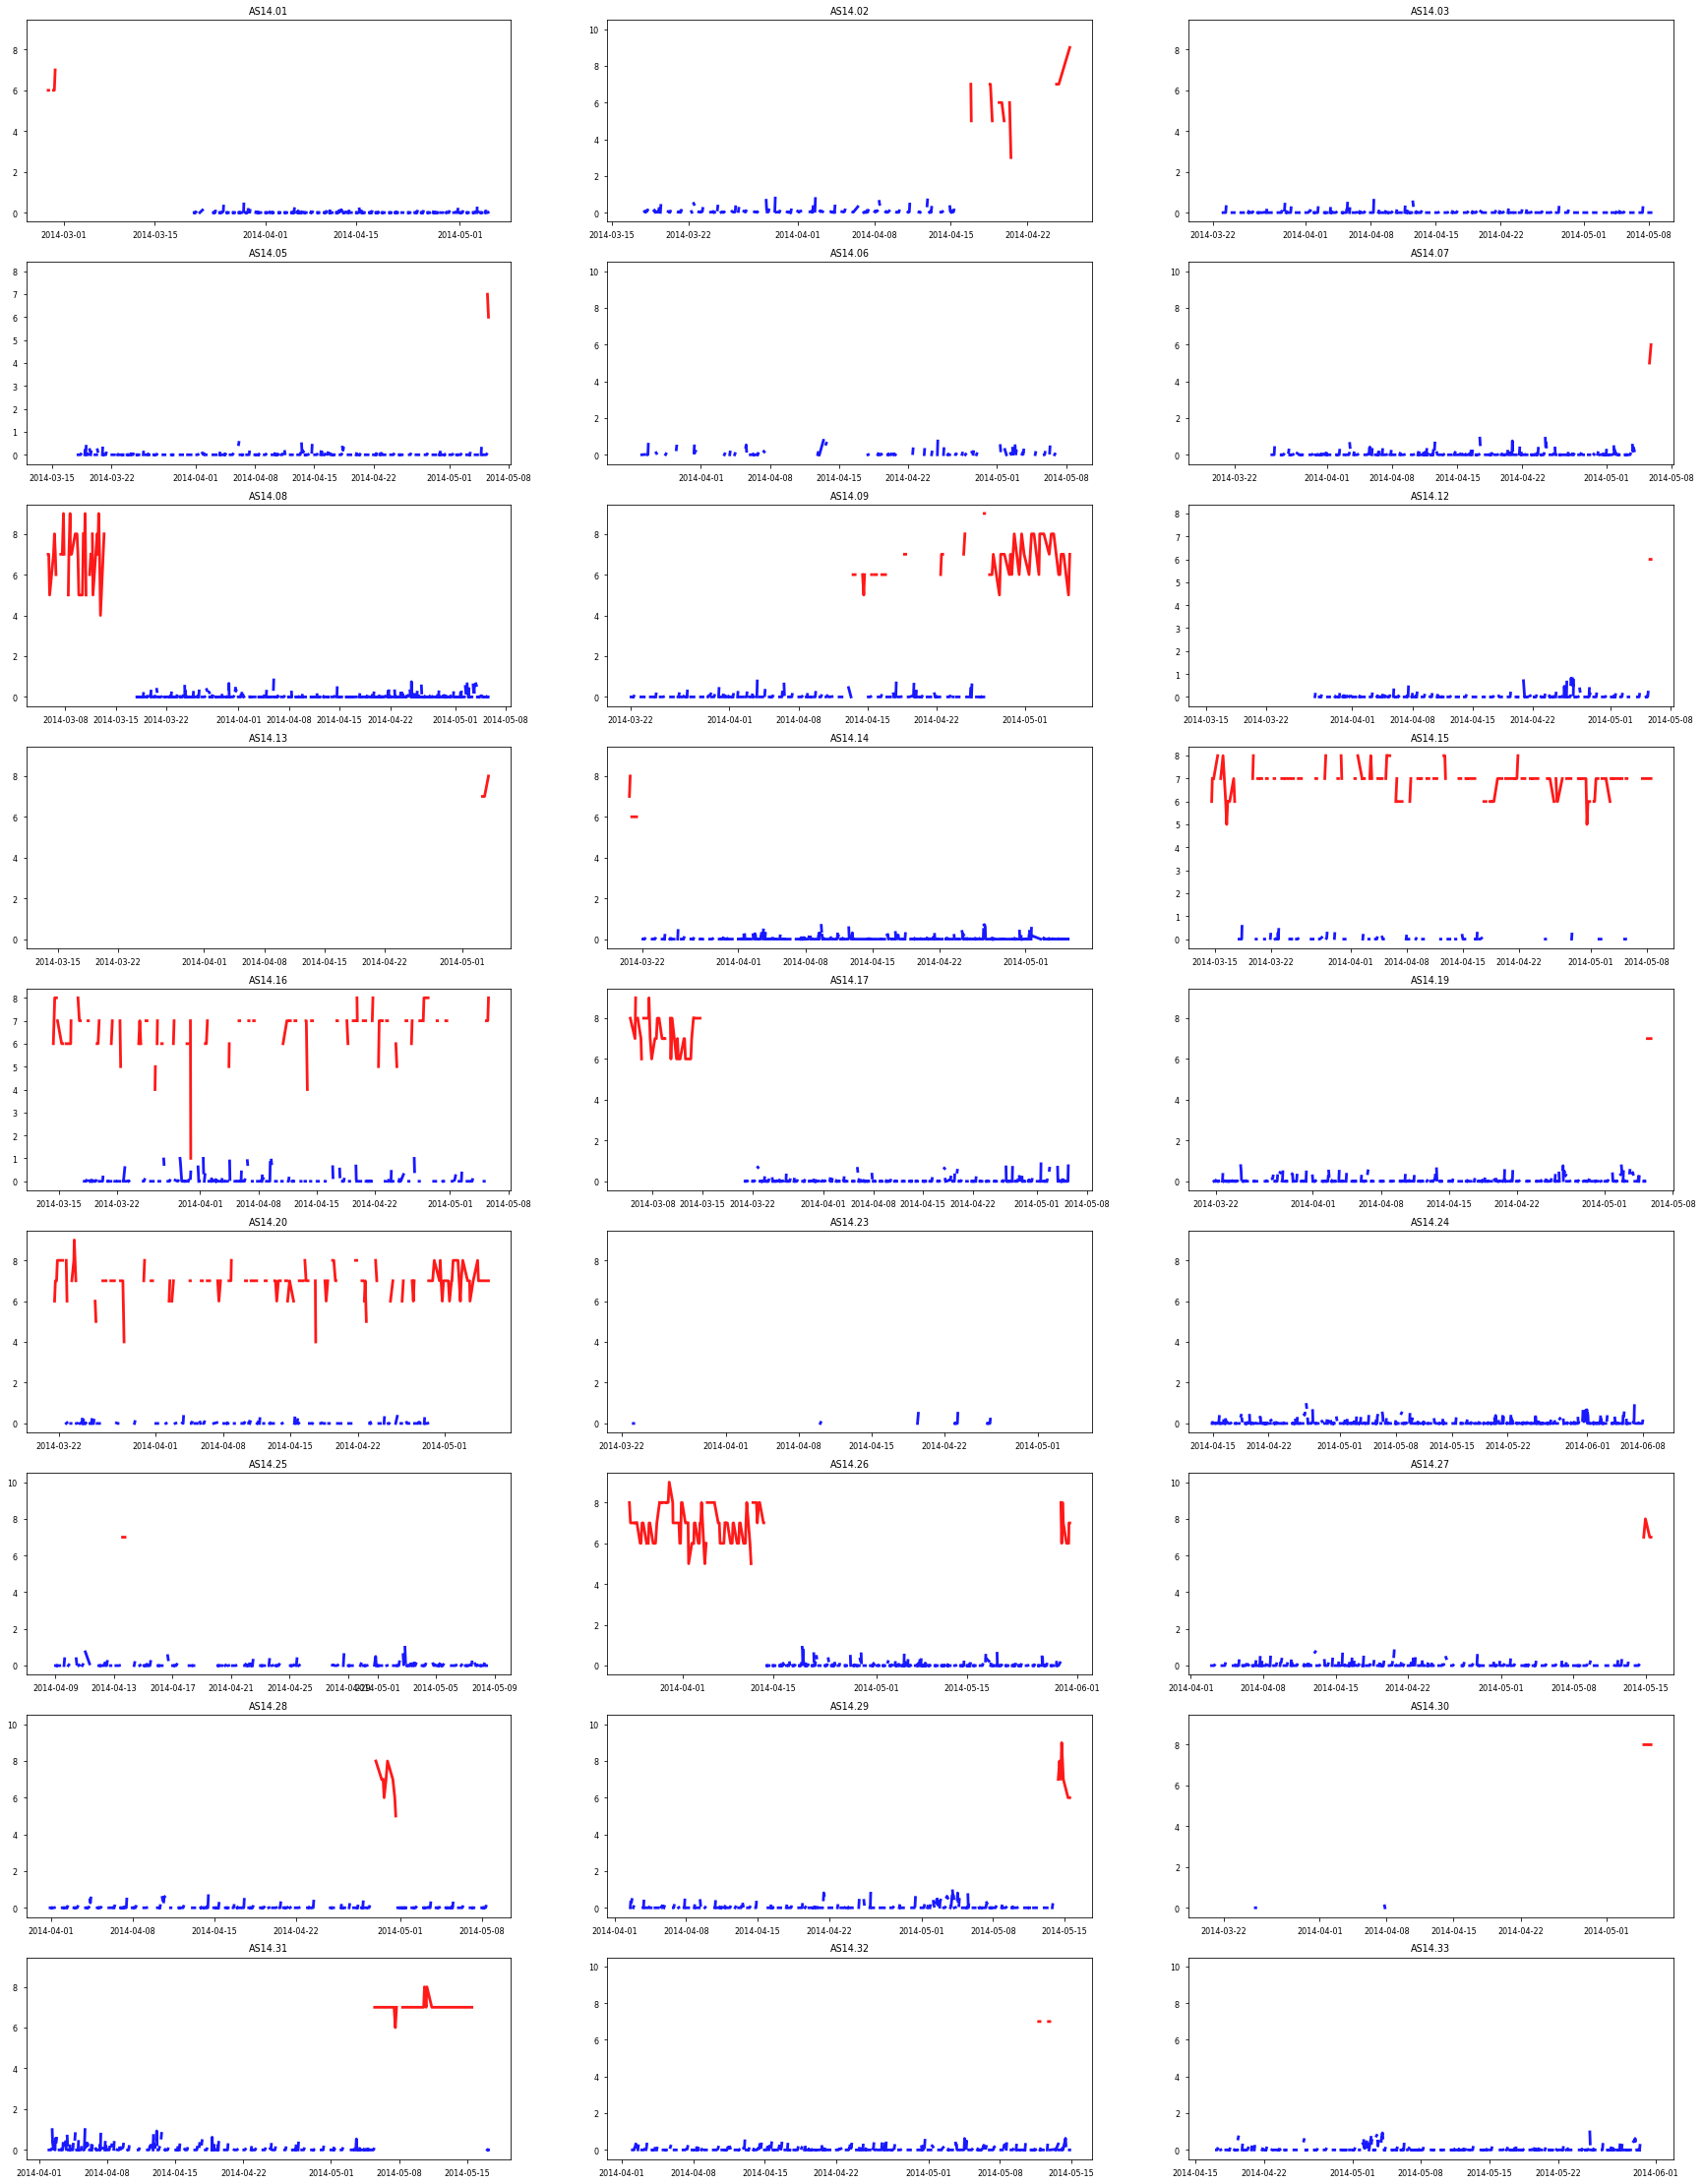

In [35]:
# 绘图查看插值结果
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(30,40))
cols=['mood','activity']
for i,val in enumerate(list(df.index.levels[0])):
    ax = fig.add_subplot(9,3, i+1)
    ax.set_title(val)
    ax.plot(df.loc[val,cols[0]], marker='', color='r', linewidth=2.8, alpha=0.9, label=val)
    ax.plot(df.loc[val,cols[1]], marker='', color='b', linewidth=2.8, alpha=0.9, label=val)

In [36]:
df.index

MultiIndex([('AS14.01', '2014-02-17 12:04:42.394000'),
            ('AS14.01', '2014-02-17 18:28:25.520000'),
            ('AS14.01', '2014-02-18 09:29:51.257000'),
            ('AS14.01', '2014-02-19 14:43:30.575000'),
            ('AS14.01', '2014-02-19 17:29:10.378000'),
            ('AS14.01', '2014-02-19 17:42:16.499000'),
            ('AS14.01', '2014-02-19 17:42:34.292000'),
            ('AS14.01', '2014-02-19 17:43:18.061000'),
            ('AS14.01', '2014-02-19 17:44:01.594000'),
            ('AS14.01', '2014-02-19 18:07:50.055000'),
            ...
            ('AS14.33', '2014-05-30 22:06:07.826000'),
            ('AS14.33', '2014-05-30 22:07:36.256000'),
            ('AS14.33', '2014-05-30 22:18:11.591000'),
            ('AS14.33', '2014-05-30 22:31:07.964000'),
            ('AS14.33', '2014-05-30 22:32:00.898000'),
            ('AS14.33', '2014-05-30 22:32:05.016000'),
            ('AS14.33', '2014-05-30 22:32:11.049000'),
            ('AS14.33', '2014-05-30 22:32:14.2400

### 表1 删除异常值前数据

In [37]:
df.describe()

variable      activity  appCat.builtin  appCat.communication  \
count     22965.000000    91285.000000          74276.000000   
mean          0.115958       19.446411             43.343792   
std           0.186946      312.914956            128.912750   
min           0.000000        0.001000              0.006000   
25%           0.000000        2.020000              5.218000   
50%           0.021739        4.038000             16.225500   
75%           0.158333        9.922000             45.475750   
max           1.000000    33960.246000           9830.777000   

variable  appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
count             27124.000000      939.000000   813.000000    5642.000000   
mean                 37.577866       21.755251   128.391615      22.578892   
std                 262.965225       39.218361   327.145246     449.601382   
min                   0.001000        0.131000     1.003000       0.003000   
25%                   1.334000        4.072000    14.148000       2.004000   
50%                   3.391500        8.026000    43.168000       3.106000   
75%                  14.922250       20.155000   123.625000       8.043750   
max               32148.677000      355.513000  5491.793000   32708.818000   

variable  appCat.other  appCat.social  appCat.travel  appCat.unknown  \
count      7650.000000   19145.000000    2846.000000      939.000000   
mean         25.810839      72.401906      45.730850       45.553006   
std         112.781355     261.551846     246.109307      119.400405   
min           0.014000       0.094000       0.080000        0.111000   
25%           7.019000       9.030000       5.086500        5.018000   
50%          10.028000      28.466000      18.144000       17.190000   
75%          16.829250      75.372000      47.227250       44.430500   
max        3892.038000   30000.906000   10452.615000     2239.937000   

variable  appCat.utilities  appCat.weather    call  circumplex.arousal  \
count          2487.000000      255.000000  5239.0         5582.000000   
mean             18.537552       20.148714     1.0           -0.098173   
std              60.959134       24.943431     0.0            1.051164   
min               0.246000        1.003000     1.0           -2.000000   
25%               3.158500        8.684000     1.0           -1.000000   
50%               8.030000       15.117000     1.0            0.000000   
75%              19.331000       25.349000     1.0            1.000000   
max            1802.649000      344.863000     1.0            2.000000   

variable  circumplex.valence         mood        screen     sms  
count            5474.000000  5628.000000  96578.000000  1798.0  
mean                0.688893     6.993870     75.335206     1.0  
std                 0.670048     1.031496    253.822497     0.0  
min                -2.000000     1.000000      0.035000     1.0  
25%                 0.000000     7.000000      5.322250     1.0  
50%                 1.000000     7.000000     20.044500     1.0  
75%                 1.000000     8.000000     62.540250     1.0  
max                 2.000000    10.000000   9867.007000     1.0

### 数据的相关性

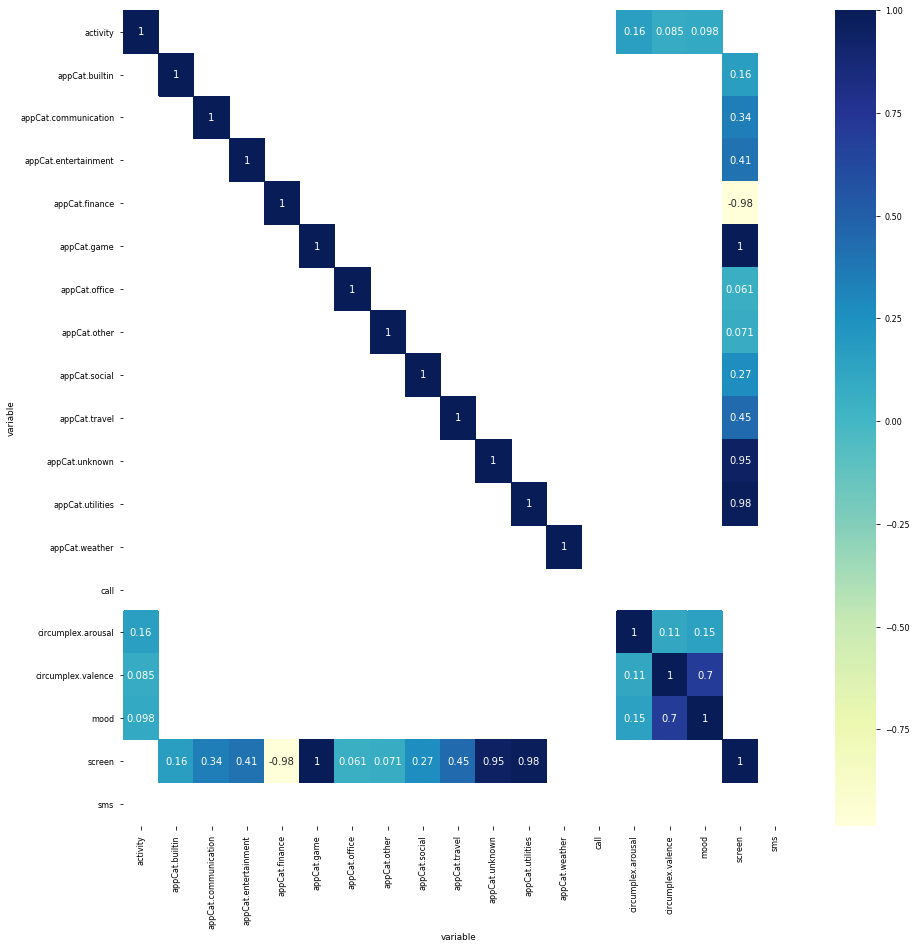

In [38]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu");

### 图1 删除异常值前数据Hish图

array([[<AxesSubplot:title={'center':'screen'}>,
        <AxesSubplot:title={'center':'appCat.builtin'}>,
        <AxesSubplot:title={'center':'appCat.communication'}>,
        <AxesSubplot:title={'center':'appCat.entertainment'}>],
       [<AxesSubplot:title={'center':'appCat.finance'}>,
        <AxesSubplot:title={'center':'appCat.game'}>,
        <AxesSubplot:title={'center':'appCat.office'}>,
        <AxesSubplot:title={'center':'appCat.other'}>],
       [<AxesSubplot:title={'center':'appCat.social'}>,
        <AxesSubplot:title={'center':'appCat.travel'}>,
        <AxesSubplot:title={'center':'appCat.unknown'}>,
        <AxesSubplot:title={'center':'appCat.utilities'}>],
       [<AxesSubplot:title={'center':'appCat.weather'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

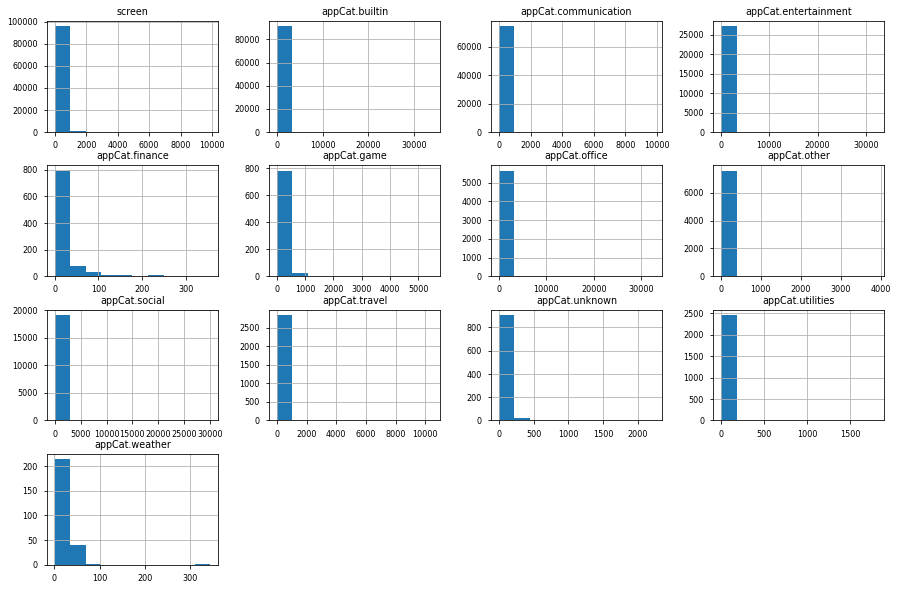

In [39]:
timecols=['screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
df.hist(timecols,figsize=(15,10))

## 替换异常值
未验证删除异常值后对结果的影响，是否执行删除需验证后决定

In [40]:
# remove outliers，选择执行
timecols=['screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
df = removeoutliers(df,timecols)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358922 entries, ('AS14.01', Timestamp('2014-02-17 12:04:42.394000')) to ('AS14.33', Timestamp('2014-05-31 12:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   activity              22965 non-null  float64
 1   appCat.builtin        91285 non-null  float64
 2   appCat.communication  74276 non-null  float64
 3   appCat.entertainment  27124 non-null  float64
 4   appCat.finance        939 non-null    float64
 5   appCat.game           813 non-null    float64
 6   appCat.office         5642 non-null   float64
 7   appCat.other          7650 non-null   float64
 8   appCat.social         19145 non-null  float64
 9   appCat.travel         2846 non-null   float64
 10  appCat.unknown        939 non-null    float64
 11  appCat.utilities      2487 non-null   float64
 12  appCat.weather        255 non-null    float64
 13  call                  5239 no

### 表2 替换异常值后数据描述

In [42]:
df.describe()

variable      activity  appCat.builtin  appCat.communication  \
count     22965.000000    91285.000000          74276.000000   
mean          0.115958        7.050873             30.757341   
std           0.186946        6.759849             32.991631   
min           0.000000        0.001000              0.006000   
25%           0.000000        2.020000              5.218000   
50%           0.021739        4.038000             16.225500   
75%           0.158333        9.922000             45.475750   
max           1.000000       21.775000            105.862375   

variable  appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
count             27124.000000      939.000000   813.000000    5642.000000   
mean                 10.317920       14.474768    83.588817       5.948709   
std                  12.788385       14.252193    93.197834       5.631424   
min                   0.001000        0.131000     1.003000       0.003000   
25%                   1.334000        4.072000    14.148000       2.004000   
50%                   3.391500        8.026000    43.168000       3.106000   
75%                  14.922250       20.155000   123.625000       8.043750   
max                  35.304625       44.279500   287.840500      17.103375   

variable  appCat.other  appCat.social  appCat.travel  appCat.unknown  \
count      7650.000000   19145.000000    2846.000000      939.000000   
mean         12.981498      51.517141      31.395787       29.504299   
std           9.327186      55.670662      32.675497       31.908903   
min           0.014000       0.094000       0.080000        0.111000   
25%           7.019000       9.030000       5.086500        5.018000   
50%          10.028000      28.466000      18.144000       17.190000   
75%          16.829250      75.372000      47.227250       44.430500   
max          31.544625     174.885000     110.438375      103.549250   

variable  appCat.utilities  appCat.weather    call  circumplex.arousal  \
count          2487.000000      255.000000  5239.0         5582.000000   
mean             12.944640       18.664055     1.0           -0.098173   
std              12.625708       13.462081     0.0            1.051164   
min               0.246000        1.003000     1.0           -2.000000   
25%               3.158500        8.684000     1.0           -1.000000   
50%               8.030000       15.117000     1.0            0.000000   
75%              19.331000       25.349000     1.0            1.000000   
max              43.589750       50.346500     1.0            2.000000   

variable  circumplex.valence         mood        screen     sms  
count            5474.000000  5628.000000  96578.000000  1798.0  
mean                0.688893     6.993870     42.247384     1.0  
std                 0.670048     1.031496     48.203883     0.0  
min                -2.000000     1.000000      0.035000     1.0  
25%                 0.000000     7.000000      5.322250     1.0  
50%                 1.000000     7.000000     20.044500     1.0  
75%                 1.000000     8.000000     62.540250     1.0  
max                 2.000000    10.000000    148.367250     1.0

### 图2 替换异常值后数据hish图

array([[<AxesSubplot:title={'center':'screen'}>,
        <AxesSubplot:title={'center':'appCat.builtin'}>,
        <AxesSubplot:title={'center':'appCat.communication'}>,
        <AxesSubplot:title={'center':'appCat.entertainment'}>],
       [<AxesSubplot:title={'center':'appCat.finance'}>,
        <AxesSubplot:title={'center':'appCat.game'}>,
        <AxesSubplot:title={'center':'appCat.office'}>,
        <AxesSubplot:title={'center':'appCat.other'}>],
       [<AxesSubplot:title={'center':'appCat.social'}>,
        <AxesSubplot:title={'center':'appCat.travel'}>,
        <AxesSubplot:title={'center':'appCat.unknown'}>,
        <AxesSubplot:title={'center':'appCat.utilities'}>],
       [<AxesSubplot:title={'center':'appCat.weather'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

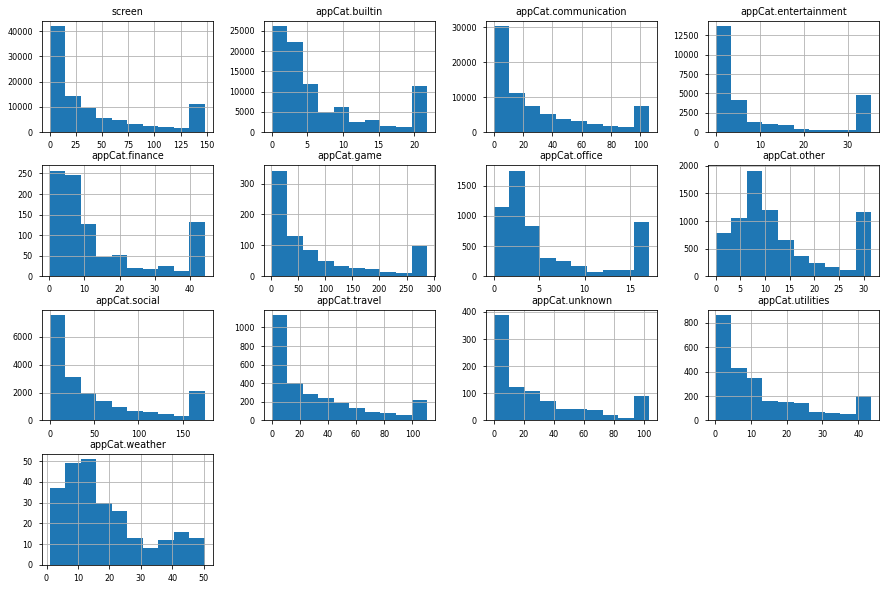

In [43]:
timecols=['screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
df.hist(timecols,figsize=(15,10))

### 2. 时间序列数据按日合并
数据集中用户每天的的数据包括了多个时间的值,需要按天合并数据,针对不同属性使用不同的统计方法,mood,circumplex.arousal,circumplex.valence,activity为不同时段的评分,因此将多个时段评分去Mean,计算出该日的评分,call,sms为是否进行了该操作,因此只要该天任意时段为1，该日就为1，因此取Max，而其余的screen,appCat.builtin等为每个时间段的时长，对其进行求Sum计算出总的时长.
合并前数据集：358922x21，合并后数据集1973x21
具体实现见函数datatransformforday

In [44]:
def datatransformforday(df):
    '''
    数据集转换，将variable转换为属性，并按日合并

    Args:
        df             ：需转换的dataframe
        
    Returns:
        转换后的dataframe
    
    '''
    
    df.reset_index(inplace=True)

    # 对每个'id' 按天合并计算，合并方法保存在polymerizationcols字典中
    polymerizationcols={'mood':'mean','circumplex.arousal':'mean','circumplex.valence':'mean','activity':'mean','call':'sum','screen':'sum',
                        'sms':'sum','appCat.builtin':'sum','appCat.communication':'sum','appCat.entertainment':'sum','appCat.finance':'sum',
                        'appCat.game':'sum','appCat.office':'sum','appCat.other':'sum','appCat.social':'sum','appCat.travel':'sum',
                        'appCat.unknown':'sum','appCat.utilities':'sum','appCat.weather':'sum'}
    df=df.groupby(['id',pd.Grouper(key='time',freq='D')]).agg(polymerizationcols).reset_index()
    df.set_index(['id','time'],inplace=True,drop=True)
    return df

df1d=datatransformforday(df)
df1d.to_csv('dataset_mood_1d.csv')
df1d.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1973 entries, ('AS14.01', Timestamp('2014-02-17 00:00:00')) to ('AS14.33', Timestamp('2014-05-31 00:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mood                  1268 non-null   float64
 1   circumplex.arousal    1268 non-null   float64
 2   circumplex.valence    1266 non-null   float64
 3   activity              1188 non-null   float64
 4   call                  1973 non-null   float64
 5   screen                1973 non-null   float64
 6   sms                   1973 non-null   float64
 7   appCat.builtin        1973 non-null   float64
 8   appCat.communication  1973 non-null   float64
 9   appCat.entertainment  1973 non-null   float64
 10  appCat.finance        1973 non-null   float64
 11  appCat.game           1973 non-null   float64
 12  appCat.office         1973 non-null   float64
 13  appCat.other          1973 non-null   

In [45]:
df1d.describe()

mood  circumplex.arousal  circumplex.valence     activity  \
count  1268.000000         1268.000000         1266.000000  1188.000000   
mean      6.990254           -0.103910            0.687632     0.120003   
std       0.736317            0.662954            0.434361     0.098301   
min       3.000000           -2.000000           -1.250000     0.000000   
25%       6.600000           -0.600000            0.400000     0.054872   
50%       7.000000            0.000000            0.800000     0.095634   
75%       7.500000            0.400000            1.000000     0.149358   
max       9.333333            2.000000            2.000000     0.566171   

              call        screen          sms  appCat.builtin  \
count  1973.000000   1973.000000  1973.000000     1973.000000   
mean      2.655347   2068.001928     0.911303      326.223489   
std       3.452197   2432.689544     1.848397      460.387269   
min       0.000000      0.000000     0.000000        0.000000   
25%       0.000000      0.000000     0.000000        0.000000   
50%       1.000000   1127.492501     0.000000      102.409000   
75%       4.000000   3646.019253     1.000000      518.751000   
max      31.000000  12942.379511    17.000000     2771.124000   

       appCat.communication  appCat.entertainment  appCat.finance  \
count           1973.000000           1973.000000     1973.000000   
mean            1157.897737            141.846563        6.888904   
std             1565.893848            289.462744       32.117763   
min                0.000000              0.000000        0.000000   
25%                0.000000              0.000000        0.000000   
50%              426.212375              0.000000        0.000000   
75%             1879.273125            158.700875        0.000000   
max            11213.609125           2730.650750      687.084000   

       appCat.game  appCat.office  appCat.other  appCat.social  appCat.travel  \
count  1973.000000    1973.000000   1973.000000    1973.000000    1973.000000   
mean     34.443846      17.010956     50.333734     499.896430      45.287587   
std     183.411590      89.696364     79.460246     949.153761     140.336475   
min       0.000000       0.000000      0.000000       0.000000       0.000000   
25%       0.000000       0.000000      0.000000       0.000000       0.000000   
50%       0.000000       0.000000     31.308000       1.007000       0.000000   
75%       0.000000       0.000000     70.062000     612.538000       0.000000   
max    3435.841500    1071.512500   1111.777375   14145.498000    1647.172750   

       appCat.unknown  appCat.utilities  appCat.weather  
count     1973.000000       1973.000000     1973.000000  
mean        14.041833         16.316938        2.412232  
std         67.064167         77.233451       14.200515  
min          0.000000          0.000000        0.000000  
25%          0.000000          0.000000        0.000000  
50%          0.000000          0.000000        0.000000  
75%          0.000000          0.000000        0.000000  
max       1734.239250       1687.552000      303.357000

### 绘图查看数据连续情况

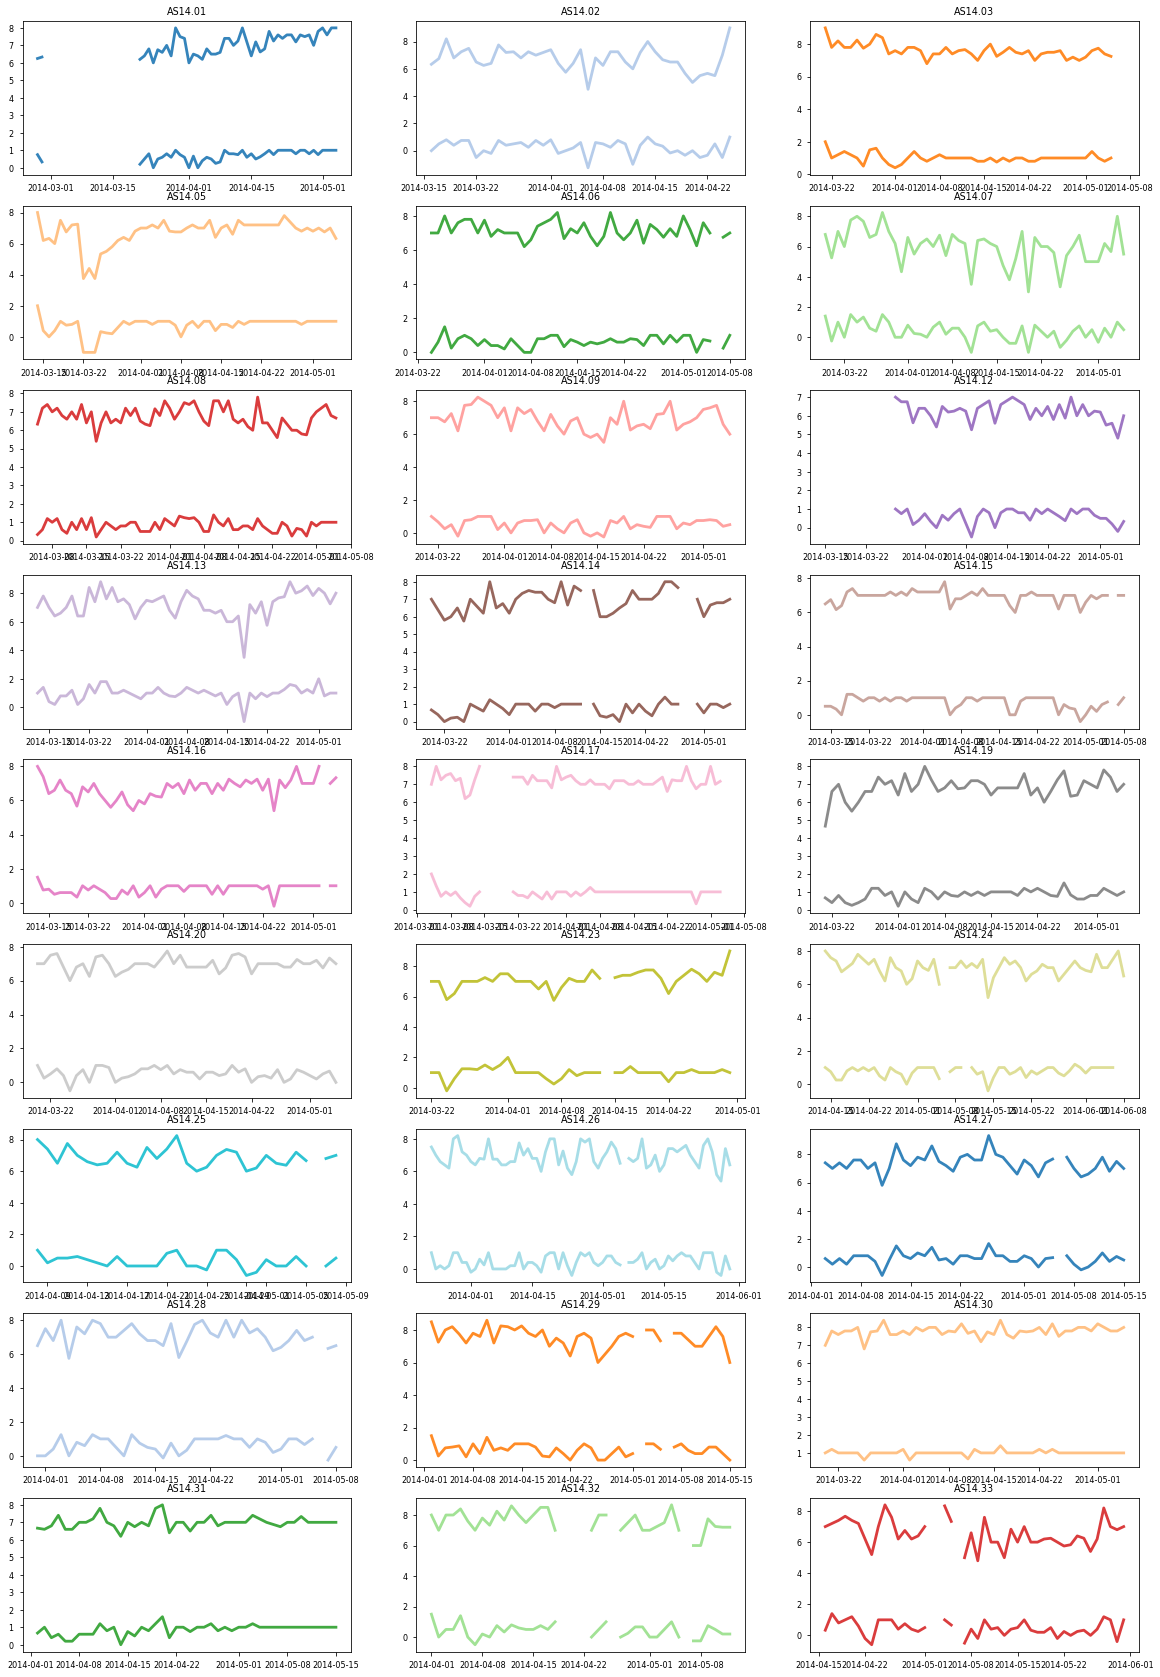

In [46]:
# 绘图查看插值结果
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(20,30))
cols=['mood','circumplex.valence']
for i,val in enumerate(list(df1d.index.levels[0])):
    ax = fig.add_subplot(9,3, i+1)
    ax.set_title(val)
    ax.plot(df1d.loc[val,cols], marker='', color=palette(i%20), linewidth=2.8, alpha=0.9, label=val)

### 删除孤立数据   
可以看到AS14.01和AS14.12有孤立的数据，如果插值会影响分析结果

In [47]:
# 删除孤立的数据
df1d.drop(index = ('AS14.01','2014-02-26'),axis = 1,inplace=True)
df1d.drop(index = ('AS14.01','2014-02-27'),axis = 1,inplace=True)
df1d.drop(index = ('AS14.12','2014-03-15'),axis = 1,inplace=True)

In [49]:
#newdf1d.info()

### 对每个ID的时间序列中间缺失数据进行插值补充

In [50]:
# 将除评分外的列中的0值替换为NaN，为插值做准备
dealcols=['call','sms','screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
df1d.loc[:,dealcols]=df1d.loc[:,dealcols].replace(to_replace=0,value=np.nan)
# 删除索引，取出id
df1d.reset_index(inplace=True)
ids = df1d.id.unique()
frames = [] 
# 分别对每个id操作
for i in ids:
    data_id = df1d[df1d.id == i]
    # 取出mood值不为NaN的时间最小值，最大值
    starttime=data_id[data_id['mood'].notnull()]['time'].min()
    endtime=data_id[data_id['mood'].notnull()]['time'].max()
    # 删除前面的值和后面的值（因为没有初始值和结束值），只补充插值中间丢失的值
    data_id = data_id.drop(data_id[(data_id['time']<starttime) | (data_id['time']>endtime)].index)
    data_id.set_index(['id','time'],inplace=True)
    #对空值替换，线性插值，也可采用别的插值方式
    data_id_inter = data_id.interpolate(axis=0)
    frames.append(data_id_inter)
    # 将不同id的数据集合并
newdf1d=pd.concat(frames,ignore_index=False)
#newdf1d.set_index(['id','time'],inplace=True)
df1d.set_index(['id','time'],inplace=True)
df1d.sort_index(inplace=True)
newdf1d.sort_index(inplace=True)

### 插值结果绘图

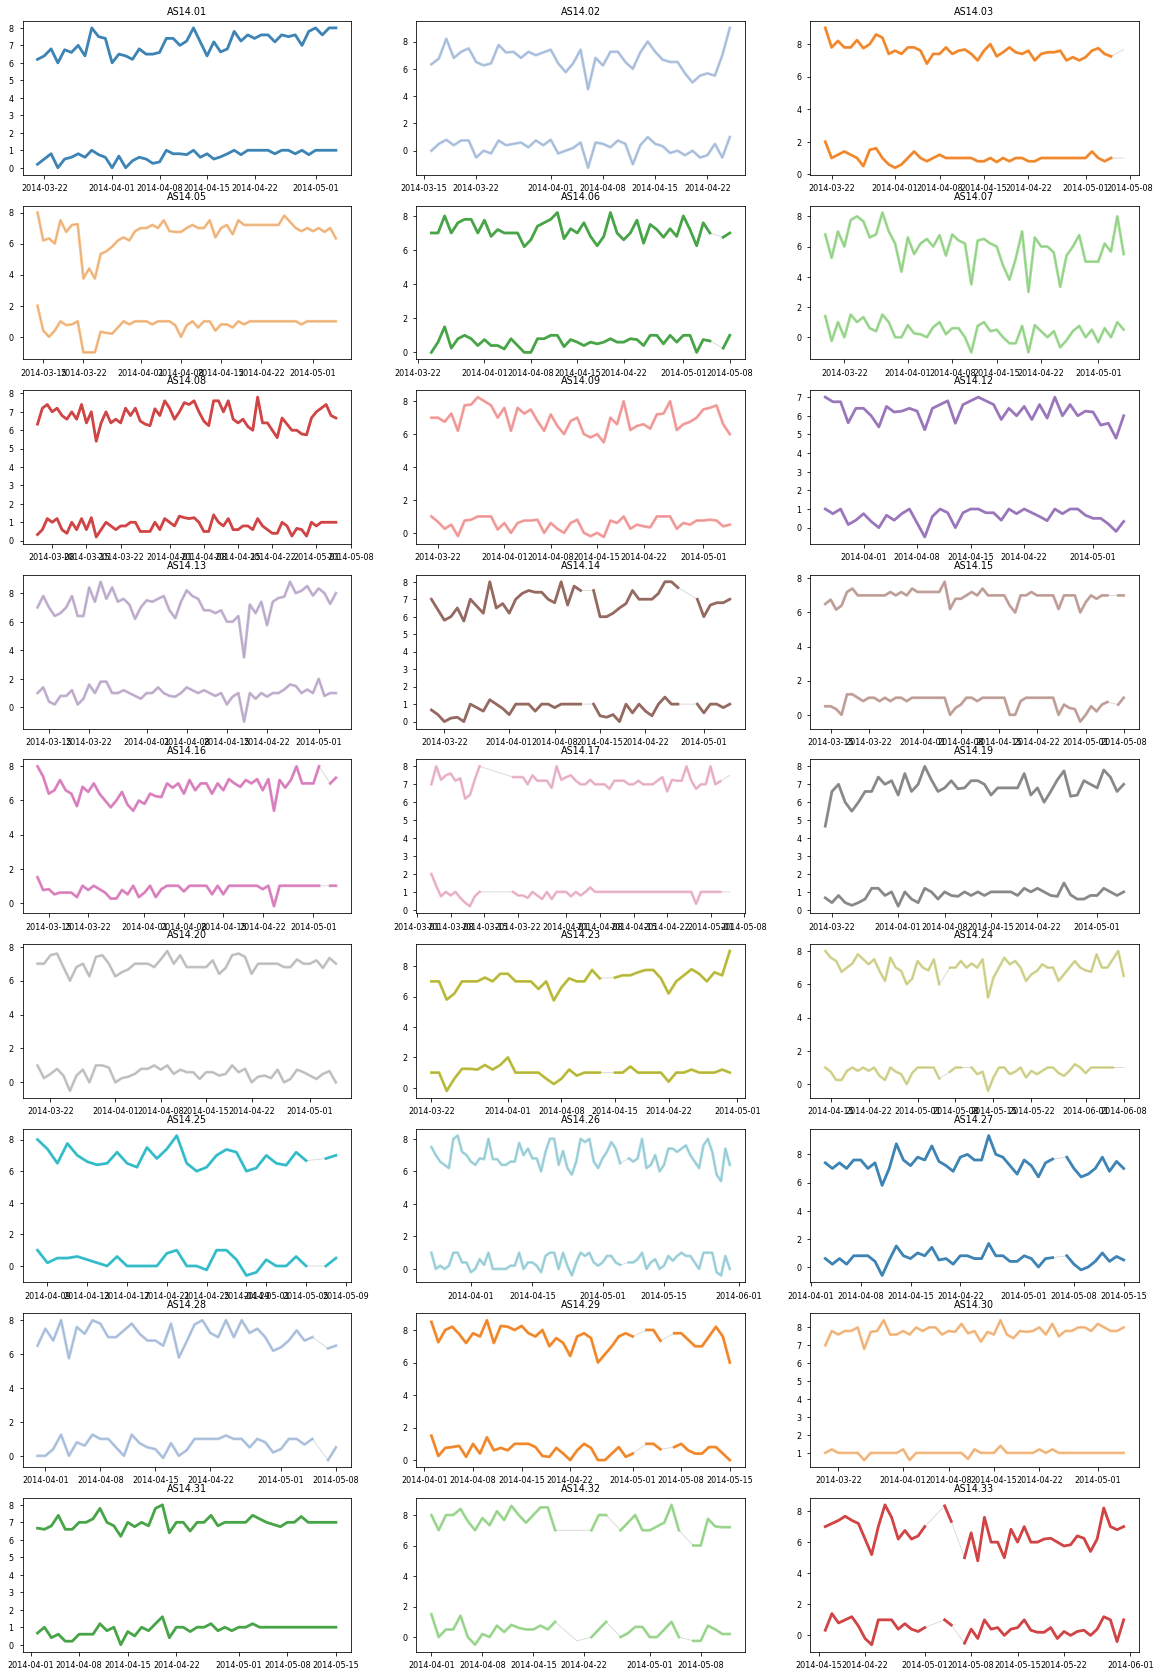

In [51]:
# 绘图查看插值结果
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(20,30))
cols=['mood','circumplex.valence']
for i,val in enumerate(list(df1d.index.levels[0])):
    ax = fig.add_subplot(9,3, i+1)
    ax.set_title(val)
    ax.plot(df1d.loc[val,cols], marker='', color=palette(i%20), linewidth=2.8, alpha=0.9, label=val)
    ax.plot(newdf1d.loc[val,cols], marker='', color='grey', linewidth=0.9, alpha=0.3)

### 数据分布

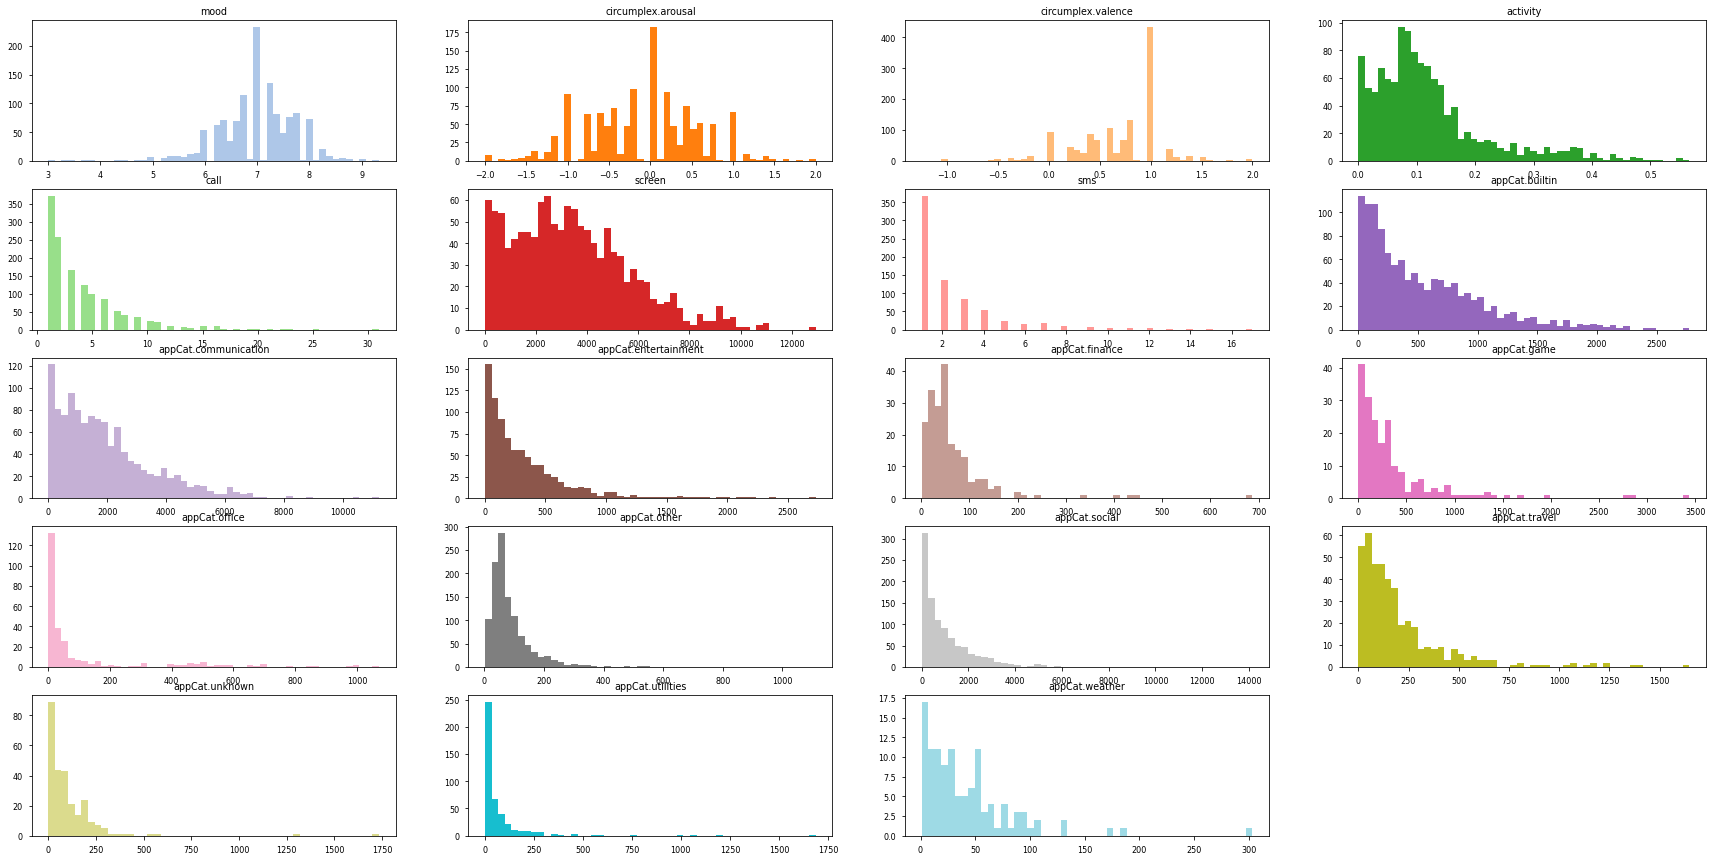

In [52]:
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(30,15))
for i,val in enumerate(list(df1d.columns.array)):
    ax = fig.add_subplot(5,4,i+1)
    data = np.asarray(df1d[val].dropna())
    ax.hist(data, bins=50, color=palette((i+1)))
    ax.set_title(val)


### 相关性分析
可以看到跟文献中的circumplex模型一致，circumplex.valence对mood的影响较大，而circumplex.arousal较弱,activity与mood有一定的相关性

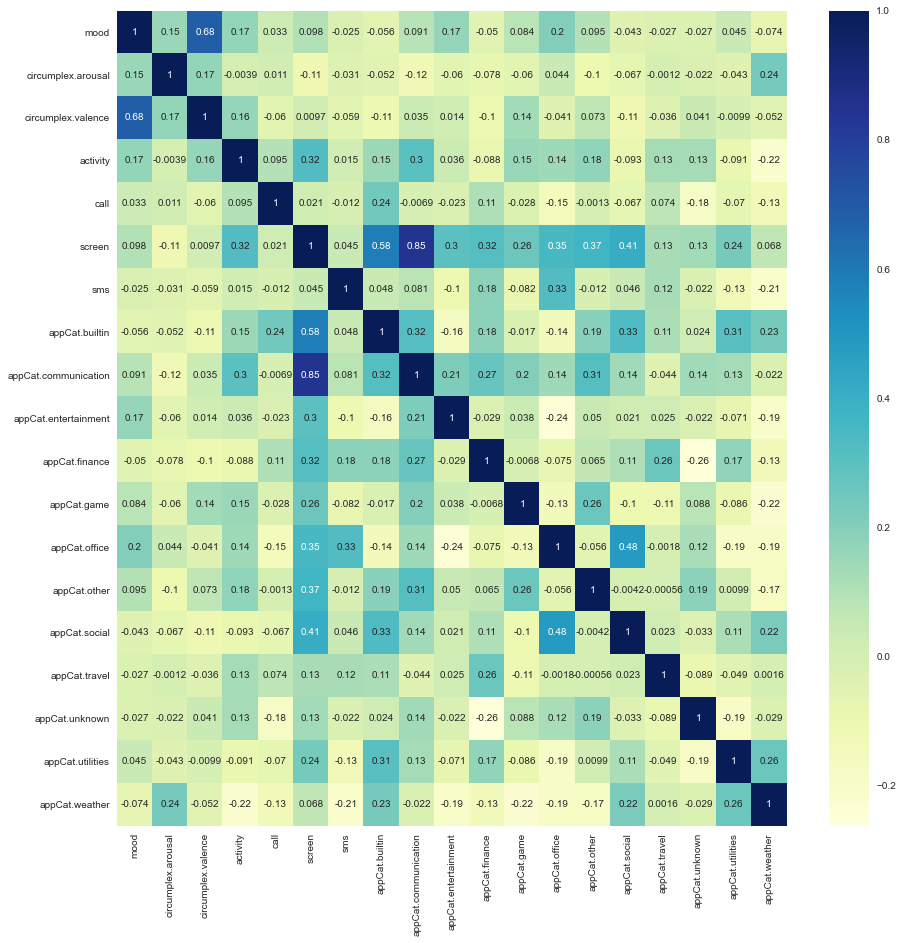

In [54]:
df1d.corr()
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df1d.corr(), annot=True, cmap="YlGnBu");

In [55]:
# 使用ADF Test
from statsmodels.tsa.stattools import adfuller

plotdf=newdf1d.copy()
plotdf.fillna(0,inplace=True)

ids = plotdf.index.levels[0].unique()
def stationary(id,column):
    series = plotdf.loc[id, column].values
    result = adfuller(series, autolag='AIC')
    return {'Column':column,'Stationary':result[1]<0.05,'ADF Statistic':result[0],'p-value':result[1]}
for id in ids:
    result=stationary(id,'mood')
    print('{} Mood Stationary:{}'.format(id,result['Stationary']))


AS14.01 Mood Stationary:True
AS14.02 Mood Stationary:True
AS14.03 Mood Stationary:True
AS14.05 Mood Stationary:False
AS14.06 Mood Stationary:True
AS14.07 Mood Stationary:True
AS14.08 Mood Stationary:True
AS14.09 Mood Stationary:True
AS14.12 Mood Stationary:True
AS14.13 Mood Stationary:False
AS14.14 Mood Stationary:True
AS14.15 Mood Stationary:True
AS14.16 Mood Stationary:True
AS14.17 Mood Stationary:True
AS14.19 Mood Stationary:True
AS14.20 Mood Stationary:True
AS14.23 Mood Stationary:False
AS14.24 Mood Stationary:True
AS14.25 Mood Stationary:True
AS14.26 Mood Stationary:True
AS14.27 Mood Stationary:True
AS14.28 Mood Stationary:True
AS14.29 Mood Stationary:True
AS14.30 Mood Stationary:True
AS14.31 Mood Stationary:True
AS14.32 Mood Stationary:True
AS14.33 Mood Stationary:True


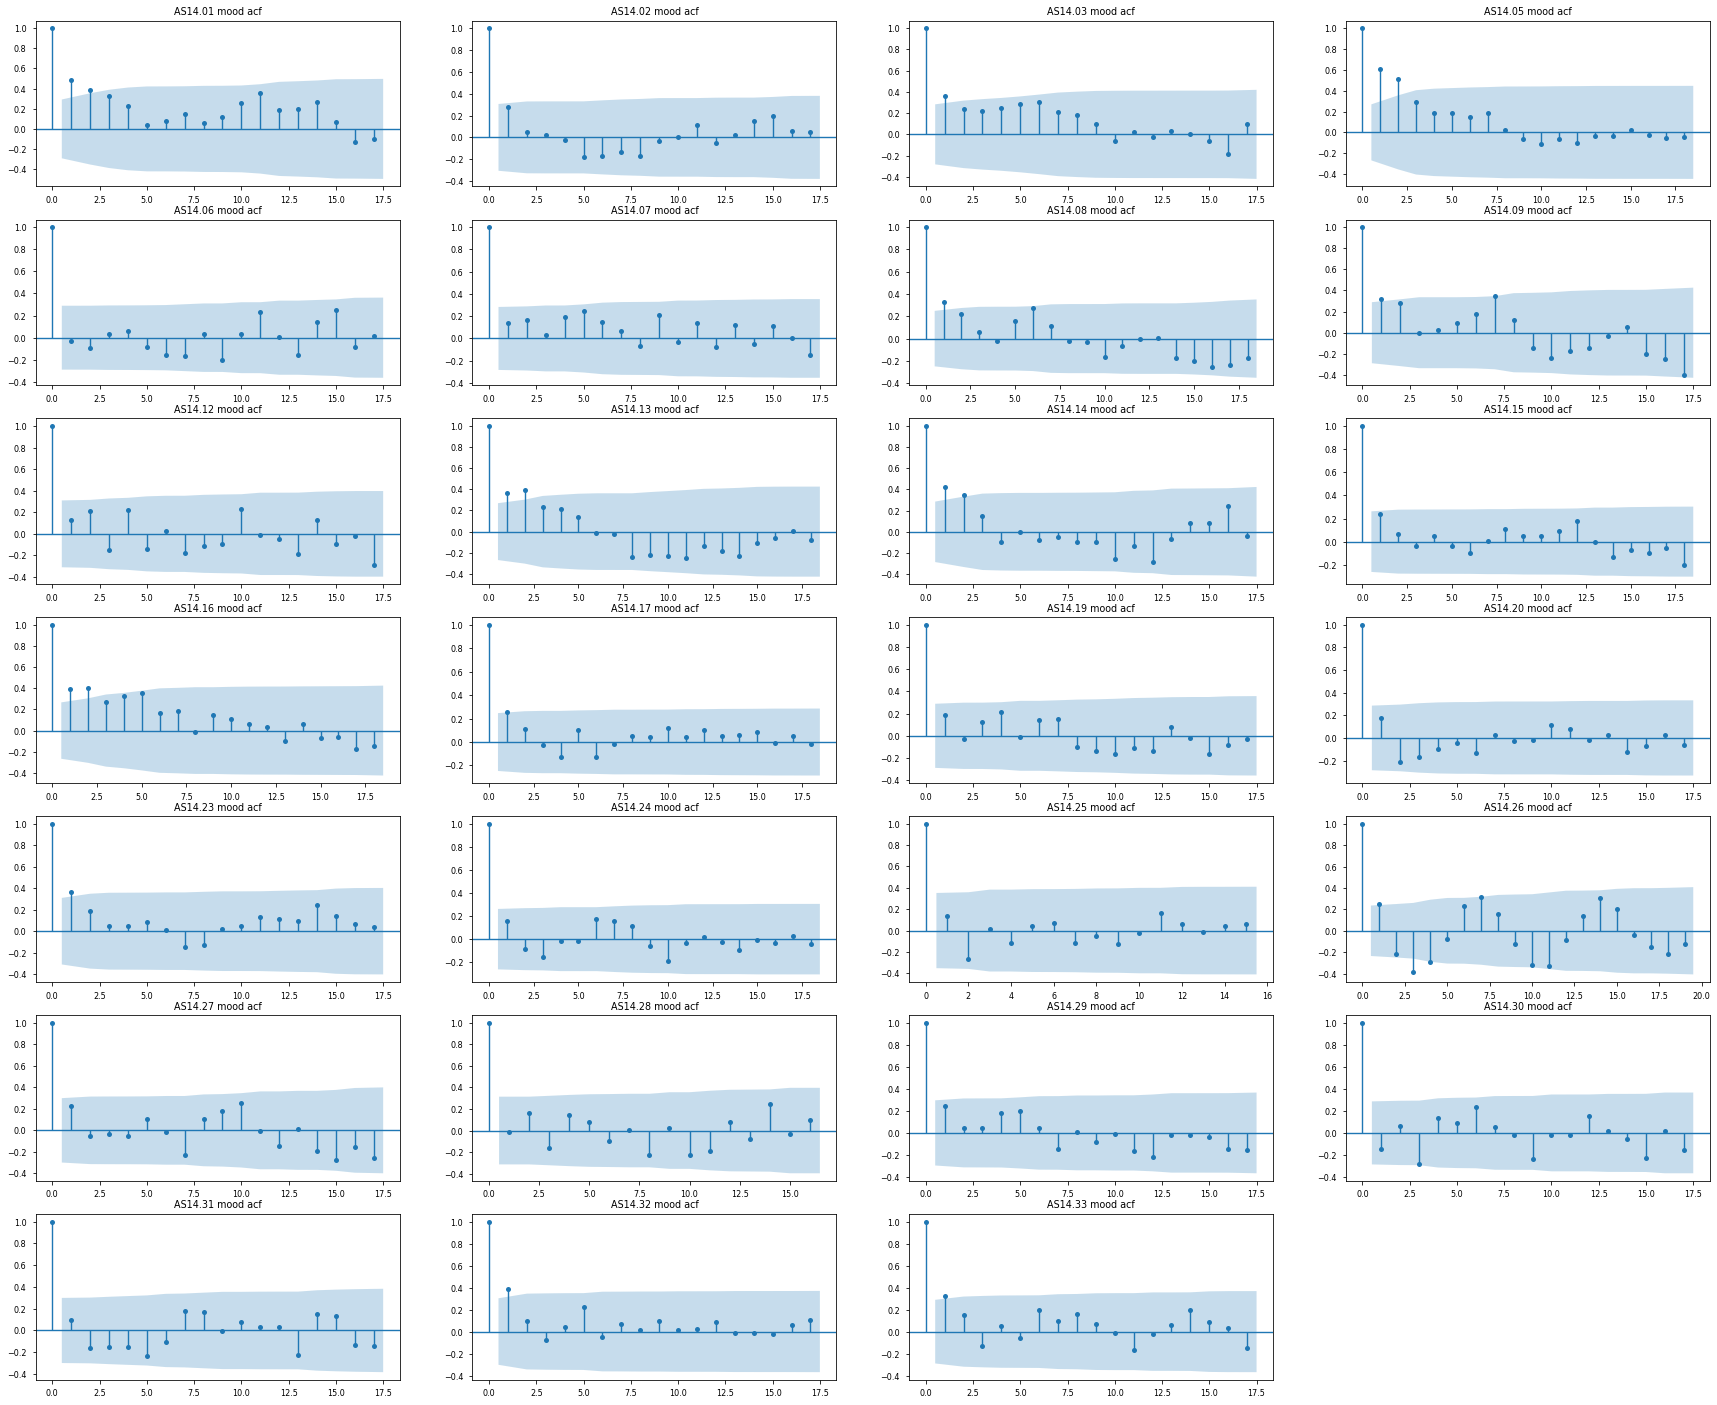

In [49]:
# 画出acf函数
# 蓝色底色区域内画出的是95%置信区间，数据落在蓝色区域内表示在统计学意义上在x轴的时间间隔下具有自相关性
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(30,25))
for i,id in enumerate(ids):
    ax = fig.add_subplot(7,4,i+1)
    series = plotdf.loc[id, 'mood'].values
    plot_acf(series,ax=ax)
    ax.set_title(id+' mood acf')

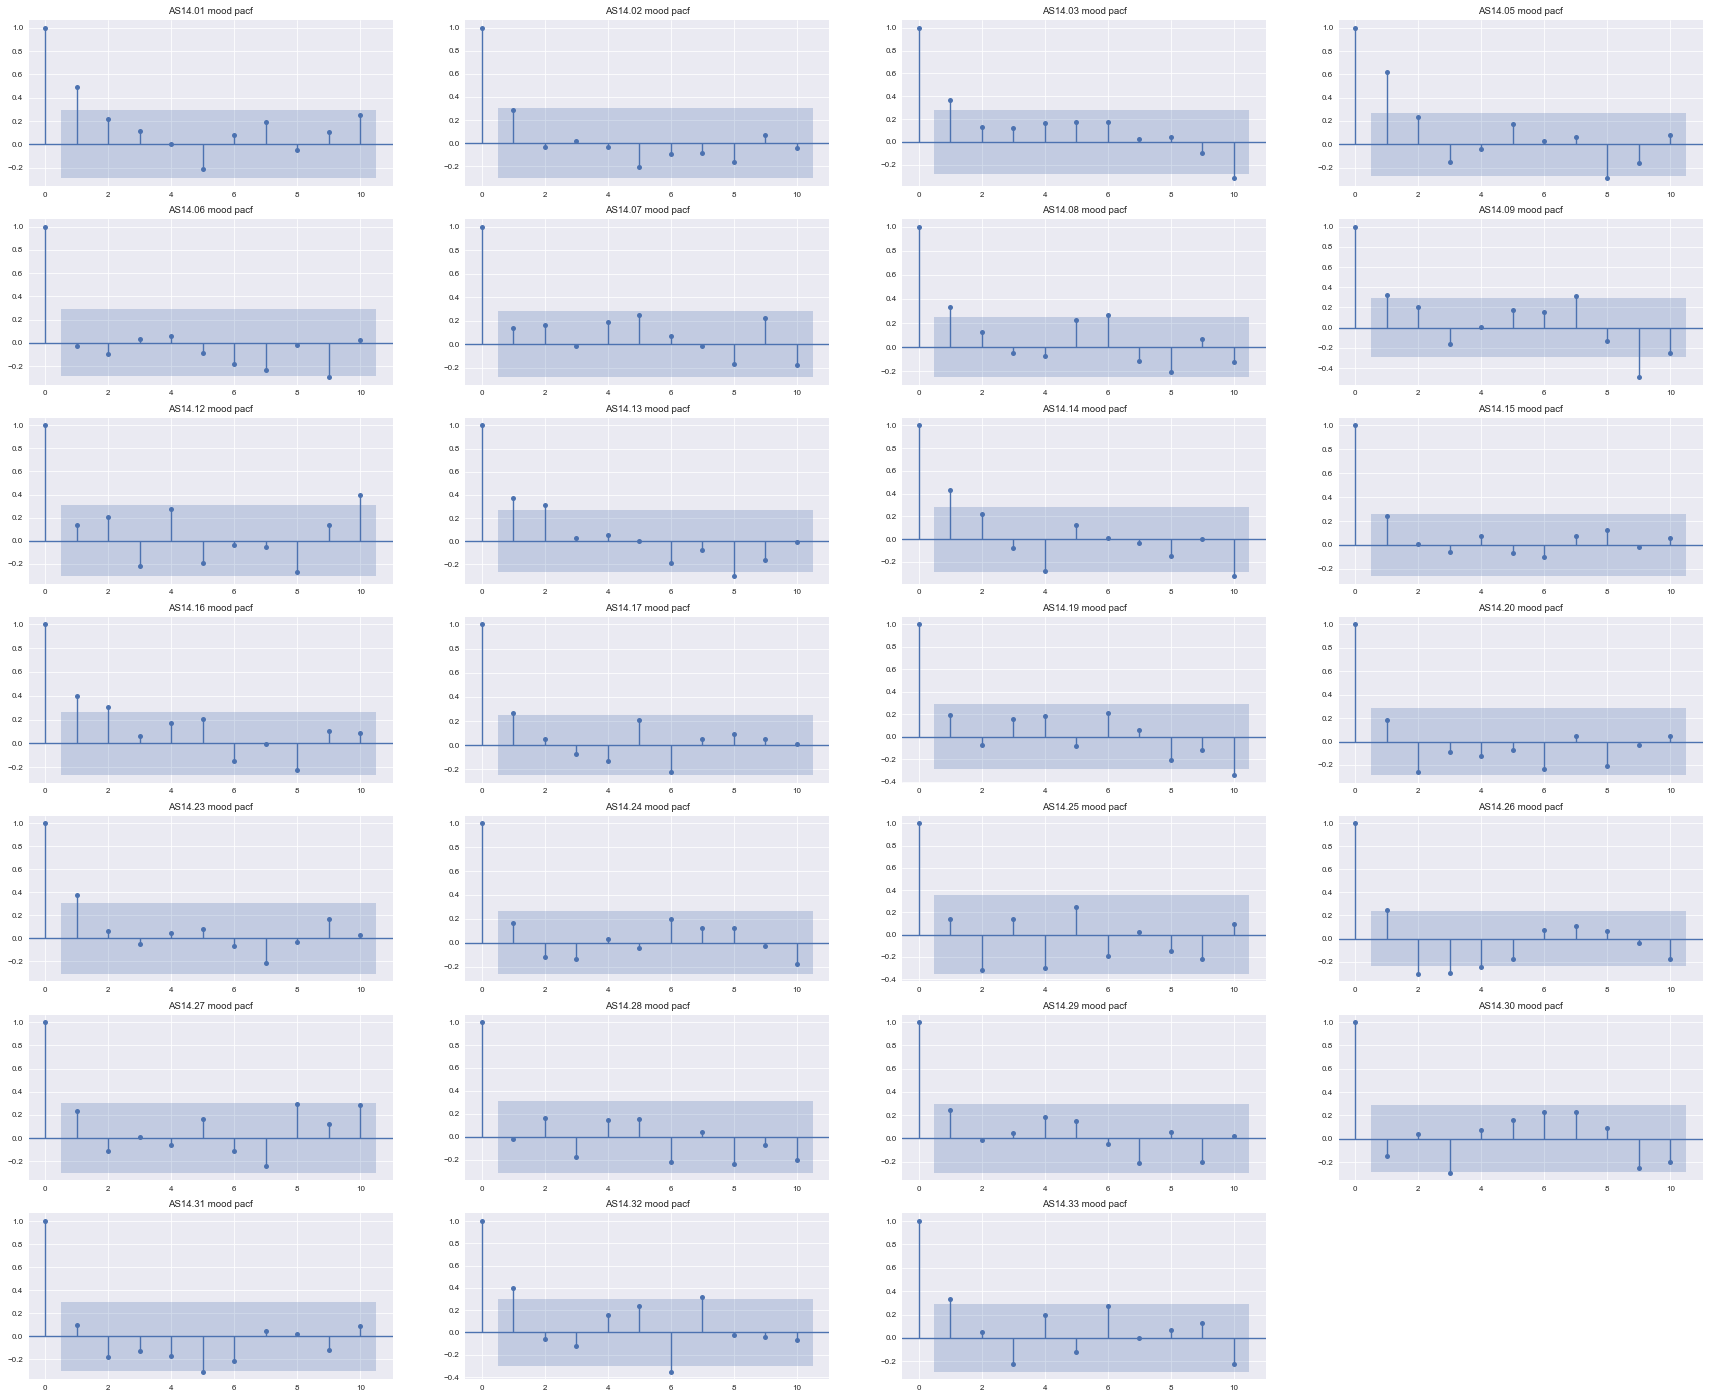

In [56]:
# 画出pacf函数
# 蓝色底色区域内画出的是95%置信区间，数据落在蓝色区域内表示在统计学意义上在x轴的时间间隔下具有自相关性
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(30,25))
for i,id in enumerate(ids):
    ax = fig.add_subplot(7,4,i+1)
    series = plotdf.loc[id, 'mood'].values
    plot_pacf(series,ax=ax,lags=10)
    ax.set_title(id+' mood pacf')


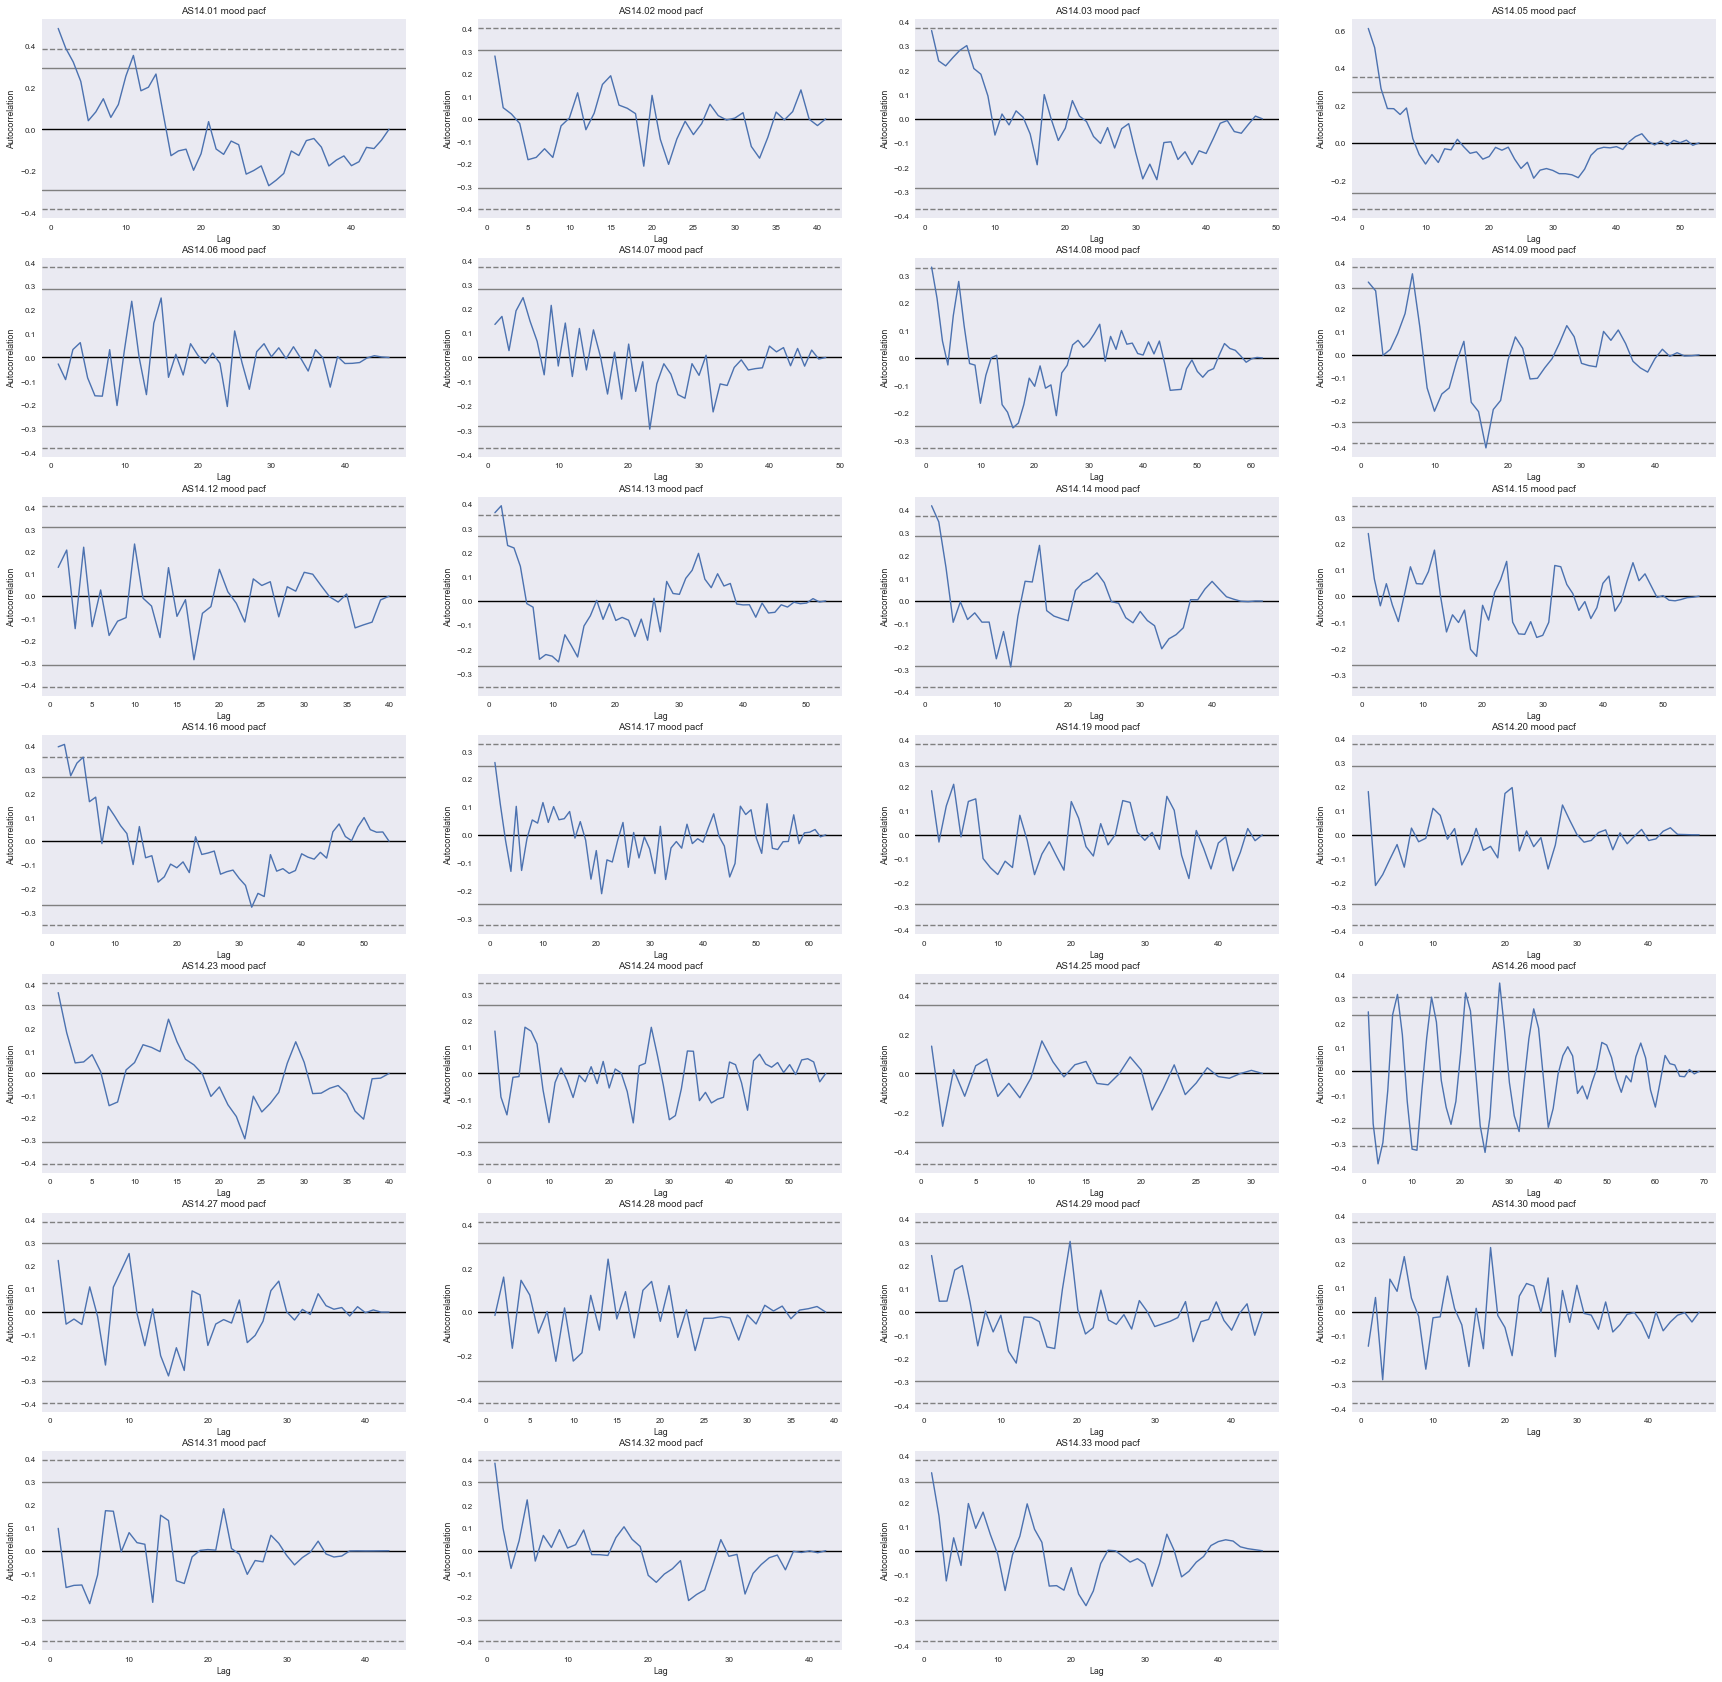

In [57]:
# 画出pacf函数
# 蓝色底色区域内画出的是95%置信区间，数据落在蓝色区域内表示在统计学意义上在x轴的时间间隔下具有自相关性
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(30,30))
for i,id in enumerate(ids):
    ax = fig.add_subplot(7,4,i+1)
    series = plotdf.loc[id, 'mood'].values
    pd.plotting.autocorrelation_plot(series,ax=ax)
    ax.set_title(id+' mood pacf')

# 从自相关性图中可以看到acf值表现出极强的相关性。

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 19)'>

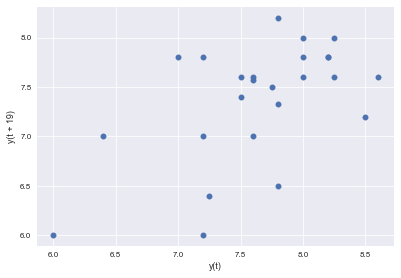

In [58]:
# 将上图AS14.31中相关性较强的lag=18单独画散点图，观察相关性
id='AS14.29'
lag=19
pd.plotting.lag_plot(plotdf.loc[id, 'mood'],lag=lag)

### 时间序列模型——ARIMA model
ARIMA模型是时序单变量模型

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
%matplotlib inline


In [60]:
# step1 划分训练集合测试集

id='AS14.05'
newdf1d=newdf1d.sort_index()
plotdf=newdf1d.copy()
y = plotdf.loc[id, 'mood']
n=round(0.2*y.shape[0])
train_data = y[:y.shape[0]-n]
test_data = y[y.shape[0]-n-1:]  #以最后n点作为待预测值


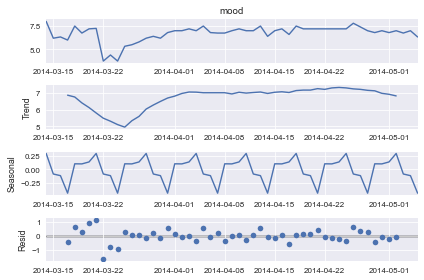

In [61]:
# 数据集不存在明显趋势项（图二），但存在季节项（图三周期性变化）
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(y, model='additive')
x = decomposed.plot()

In [62]:
# step2，检查平稳性
#原假设是不平稳的，1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设，
# adf大于三个level的统计值。所以是不平稳的，需要进行一阶差分后，再进行检验。
# p-value是否<0.05,非常接近0，接近0，则是平稳的，否则，不平稳。
result = adfuller(y, autolag='AIC')
print(result)
print('ADF Statistic',result[0],'p-value:',result[1],'Stationary:',result[1]<0.05)

(-2.6302208516450016, 0.08691069199632512, 2, 50, {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}, 21.207385984403587)
ADF Statistic -2.6302208516450016 p-value: 0.08691069199632512 Stationary: False


In [63]:
# setp3,对于平稳可不运行该step，对不平稳，进行差分处理，再次进行step2,确定d值
train_data = train_data.diff().dropna()
test_data = test_data.diff().dropna()

### 计算白噪声

In [64]:
# step4 白噪声检验
# 原假设为白噪声，lb_pvalue<0.05时拒绝原假设，非白噪声
from statsmodels.stats.diagnostic import acorr_ljungbox as ljbox
ljbox(y, lags=1,return_df=True)

lb_stat  lb_pvalue
1  20.882841   0.000005

Text(0.5, 1.0, 'AS14.05 mood pacf')

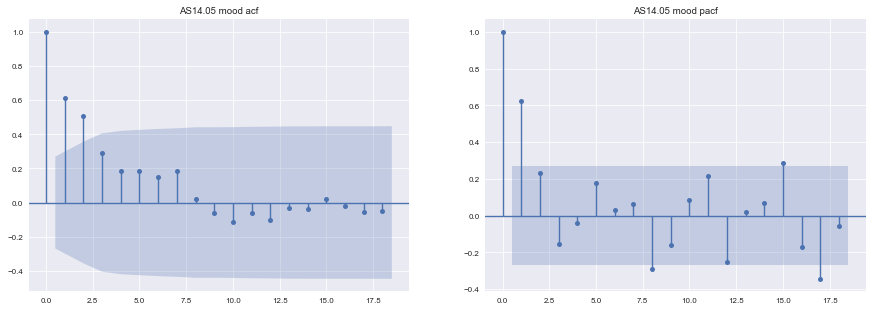

In [65]:
# step5 画出acf函数,确定p，q
# 蓝色底色区域内画出的是95%置信区间，数据落在蓝色区域内表示在统计学意义上在x轴的时间间隔下具有自相关性
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
series = y.values
plot_acf(series,ax=ax)
ax.set_title(id+' mood acf')
ax = fig.add_subplot(1,2,2)
series = y.values
plot_pacf(series,ax=ax)
ax.set_title(id+' mood pacf')

In [66]:
# step6 拟合模型
model=ARIMA(train_data, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   mood   No. Observations:                   41
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -55.136
Date:                Mon, 18 Apr 2022   AIC                            114.272
Time:                        18:07:48   BIC                            117.650
Sample:                    03-15-2014   HQIC                           115.493
                         - 04-24-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6765      0.092     -7.382      0.000      -0.856      -0.497
sigma2         0.9081      0.113      8.065      0.000       0.687       1.129
Ljung-Box (L1) (Q):                   1.31   Jarque-

C:\Users\JSJ\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JSJ\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JSJ\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [67]:
# 拟合模型，自动选择参数
arima_model = auto_arima(train_data, start_p=0, d=1,start_q=0, max_p=8,max_d=8,max_q=8,
                         start_P=0, D=1, start_Q=0, max_P=8, max_D=8, max_Q=8, m=12, seasonal=True,trace=True,n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=115.332, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=99.352, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=97.757, Time=0.01 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=99.321, Time=0.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=96.869, Time=0.01 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=98.180, Time=0.03 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=98.120, Time=0.03 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=100.078, Time=0.12 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=98.825, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=98.178, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=92.760, Time=0.02 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=93.912, Time=0.05 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=93.822, 

In [68]:
# 查看模型
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   41
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                 -43.380
Date:                             Mon, 18 Apr 2022   AIC                             92.760
Time:                                     18:07:57   BIC                             96.757
Sample:                                          0   HQIC                            93.982
                                              - 41                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3638      0.256     -1.423      0.155      -0.865       0.137
ma.L1         -0.9286      0.259     -3.587      0.000      -1.436      -0.421
sigma2         1.1789      0.344      3.424      0.001       0.504       1.854
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                17.50
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.83
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

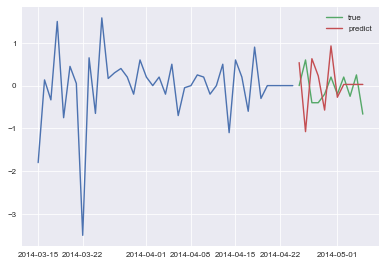

In [74]:
# step5，预测时间序列，并和真实值比较
pred = pd.DataFrame(arima_model.predict(n_periods=n),columns=['predicted'],index=test_data.index)
plt.plot(train_data)
plt.plot(test_data,label='true')
plt.plot(pred,label='predict')
plt.legend();

### 模型评价

In [75]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score


RMSE = mean_squared_error(test_data,pred)**0.5 
print('RMSE=',RMSE)

RMSE= 0.7299873953731537


### 时间序列模型——向量自回归模型（VAR）
该模型未做完

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
%matplotlib inline

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358922 entries, 0 to 358921
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    358922 non-null  object        
 1   time                  358922 non-null  datetime64[ns]
 2   activity              22965 non-null   float64       
 3   appCat.builtin        91285 non-null   float64       
 4   appCat.communication  74276 non-null   float64       
 5   appCat.entertainment  27124 non-null   float64       
 6   appCat.finance        939 non-null     float64       
 7   appCat.game           813 non-null     float64       
 8   appCat.office         5642 non-null    float64       
 9   appCat.other          7650 non-null    float64       
 10  appCat.social         19145 non-null   float64       
 11  appCat.travel         2846 non-null    float64       
 12  appCat.unknown        939 non-null     float64       
 13 

### 合并数据属性

In [87]:
# 合并属性
# appCat.game,appCat.entertainment 都应属于entertainment类，appCat.communication,appCat.social 都应属于social类
# appCat.travel,appCat.utilities,appCat.weather 都属于tool类，appCat.other,appCat.unknow 属于other类
# call,sms 属于call类,但数据计数类不能与social的时间类合并
newdf1d=newdf1d.sort_index()
df=newdf1d.loc['AS14.02'].copy()
df['appCat.entertainment'] = df[['appCat.game','appCat.entertainment']].sum(axis=1, skipna=True)
df['appCat.social'] = df[['appCat.communication','appCat.social']].sum(axis=1, skipna=True)
df['appCat.tools'] = df[['appCat.travel','appCat.utilities','appCat.weather']].sum(axis=1, skipna=True)
df['appCat.other'] = df[['appCat.other','appCat.unknown']].sum(axis=1, skipna=True)
df['call'] = df[['call','sms']].sum(axis=1, skipna=True)
columns = ['appCat.game','appCat.communication','appCat.travel','appCat.utilities','appCat.weather','appCat.unknown','sms']
df = df.drop(columns=columns, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2014-03-16 to 2014-04-25
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mood                  41 non-null     float64
 1   circumplex.arousal    41 non-null     float64
 2   circumplex.valence    41 non-null     float64
 3   activity              40 non-null     float64
 4   call                  41 non-null     float64
 5   screen                41 non-null     float64
 6   appCat.builtin        41 non-null     float64
 7   appCat.entertainment  41 non-null     float64
 8   appCat.finance        0 non-null      float64
 9   appCat.office         0 non-null      float64
 10  appCat.other          41 non-null     float64
 11  appCat.social         41 non-null     float64
 12  appCat.tools          41 non-null     float64
dtypes: float64(13)
memory usage: 4.5 KB


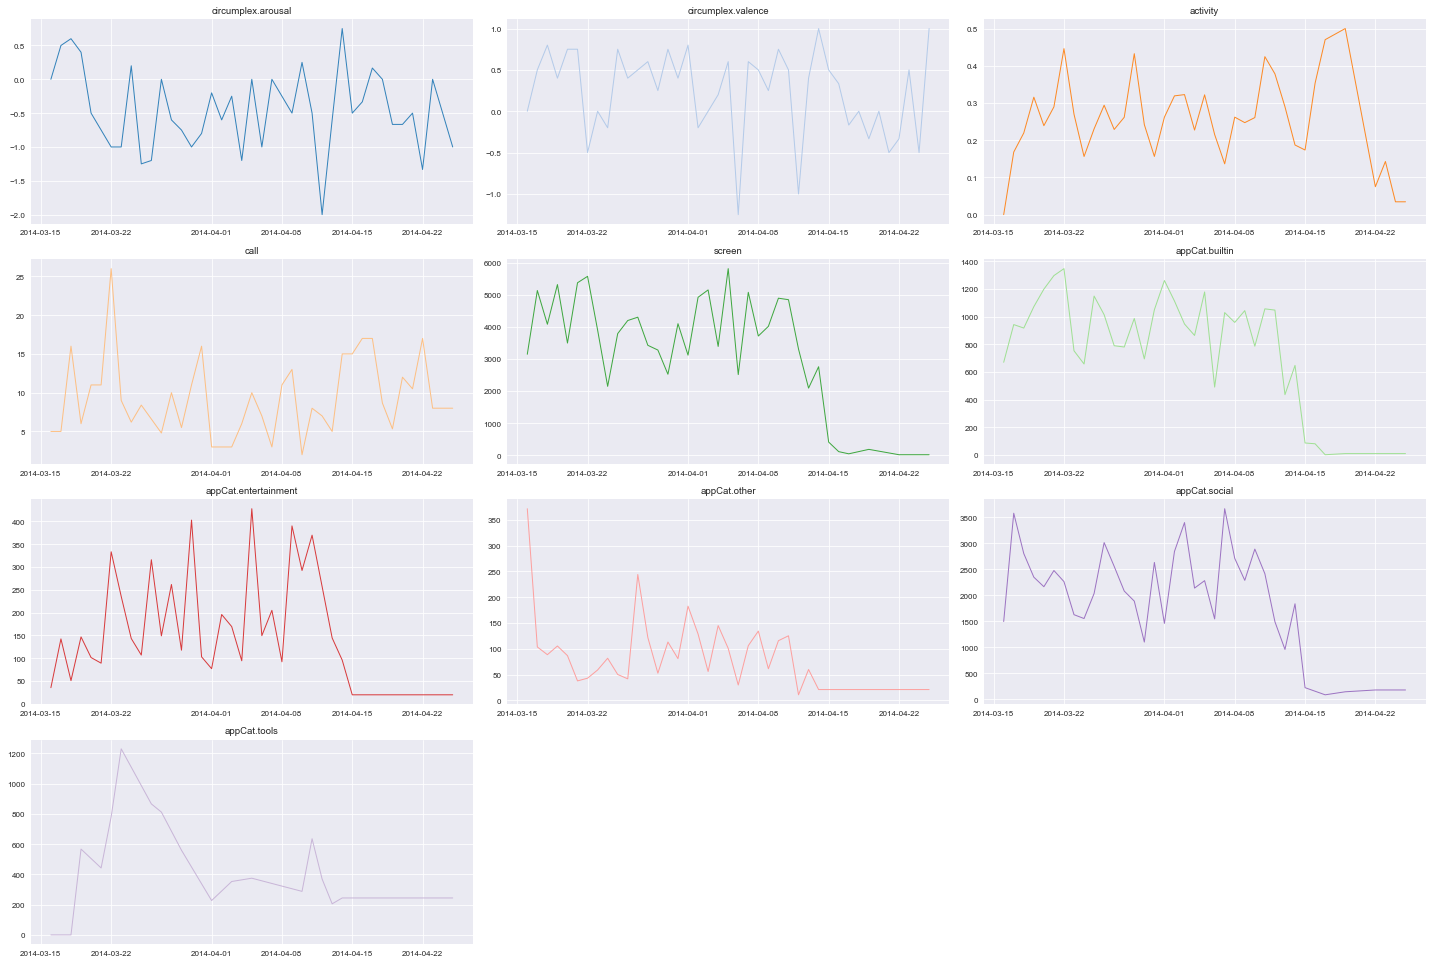

In [88]:
# 画出各属性时间序列的图像

# 删除空列
df.dropna(axis=1,how='all',inplace=True)
# 替换NaN值
df.replace(to_replace=np.nan,value=0,inplace=True)
colnum=len(df.columns)
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(20,30))
for i in range(colnum-1):
    ax = fig.add_subplot(9,3, i+1)
    #data = df[df.columns[i+1]].values
    ax.plot(df[df.columns[i+1]], marker='', color=palette(i%20), linewidth=1, alpha=0.9)
    ax.set_title(df.columns[i+1])
plt.tight_layout()


In [89]:
# step2：Granger’s Causality Test ， 检验不同序列之间存在互相影响
maxlag=12
test='ssr_chi2test'
variables=df.columns
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

mood_x  circumplex.arousal_x  circumplex.valence_x  \
mood_y                     1.0                   0.0                   0.0   
circumplex.arousal_y       0.0                   1.0                   0.0   
circumplex.valence_y       0.0                   0.0                   1.0   
activity_y                 0.0                   0.0                   0.0   
call_y                     0.0                   0.0                   0.0   
screen_y                   0.0                   0.0                   0.0   
appCat.builtin_y           0.0                   0.0                   0.0   
appCat.entertainment_y     0.0                   0.0                   0.0   
appCat.other_y             0.0                   0.0                   0.0   
appCat.social_y            0.0                   0.0                   0.0   
appCat.tools_y             0.0                   0.0                   0.0   

                        activity_x  call_x  screen_x  appCat.builtin_x  \
mood_y                      0.0000  0.0000    0.0000            0.0078   
circumplex.arousal_y        0.0000  0.0000    0.0000            0.0000   
circumplex.valence_y        0.0000  0.0000    0.0904            0.0000   
activity_y                  1.0000  0.0000    0.0000            0.0000   
call_y                      0.0000  1.0000    0.0000            0.0000   
screen_y                    0.0485  0.0000    1.0000            0.0000   
appCat.builtin_y            0.0000  0.0000    0.0000            1.0000   
appCat.entertainment_y      0.0000  0.0000    0.0000            0.0000   
appCat.other_y              0.0000  0.0001    0.0000            0.0000   
appCat.social_y             0.0000  0.0000    0.0000            0.0000   
appCat.tools_y              0.0321  0.0000    0.0000            0.0001   

                        appCat.entertainment_x  appCat.other_x  \
mood_y                                     0.0             0.0   
circumplex.arousal_y                       0.0             0.0   
circumplex.valence_y                       0.0             0.0   
activity_y                                 0.0             0.0   
call_y                                     0.0             0.0   
screen_y                                   0.0             0.0   
appCat.builtin_y                           0.0             0.0   
appCat.entertainment_y                     1.0             0.0   
appCat.other_y                             0.0             1.0   
appCat.social_y                            0.0             0.0   
appCat.tools_y                             0.0             0.0   

                        appCat.social_x  appCat.tools_x  
mood_y                           0.0000          0.0000  
circumplex.arousal_y             0.0000          0.0000  
circumplex.valence_y             0.0042          0.0000  
activity_y                       0.0000          0.0000  
call_y                           0.0000          0.0000  
screen_y                         0.0000          0.0000  
appCat.builtin_y                 0.0000          0.0000  
appCat.entertainment_y           0.0000          0.0000  
appCat.other_y                   0.0000          0.0000  
appCat.social_y                  1.0000          0.0001  
appCat.tools_y                   0.0000          1.0000

在输出结果中，index以y结尾，表示响应变量，column以x结尾，表示预测变量，如果p值小于0.05表明存在格兰杰因果性。  
因此根据检验数据，完全有理由使用VAR模型

In [90]:
# step3：ADF测试，检验单个变量是否平稳
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [91]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "mood" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8851
 No. Lags Chosen       = 0
 Critical value 1%     = -3.606
 Critical value 5%     = -2.937
 Critical value 10%    = -2.607
 => P-Value = 0.0021. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "circumplex.arousal" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8522
 No. Lags Chosen       = 1
 Critical value 1%     = -3.61
 Critical value 5%     = -2.939
 Critical value 10%    = -2.608
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "circumplex.valence" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


有些变量不具有平稳性，需要进一步进行协整检验（cointegration test）。  
一般来说进行协整检验的步骤如下：  
1.单独检验单个变量是否平稳，使用ADF test, KPSS test, PP test等方法  
2.如果发现单个序列不平稳，则需要进一步进行协整检验。进行协整检验的目的是当每个变量本身不平稳，有可能他们在某些线性组合下是平稳的。如果两个时间序列是协整的，则表明他们具有长期的，统计学显著的关联，使用Johansen, Engle-Granger, and Phillips-Ouliaris等方法。

In [92]:
# step4: 协整检验，检验多变量平稳性
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_train)

C:\Users\JSJ\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:577: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "


SystemError: <cyfunction Timestamp.__new__ at 0x000002C951403860> returned a result with an error set

In [ ]:
# step5：划分训练集和测试集
nobs = 10  # 最后nobs个时间点作为测试集
df_train,df_test = df[0:-nobs], df[-nobs:]

In [86]:
# step6：使用VAR之间，先差分处理使单个变量变得平稳
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [82]:
# 有些变量仍然不平稳，可多次进行差分,直至平稳
df_differenced = df_differenced.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

NameError: name 'df_differenced' is not defined

In [257]:
# step7：选择模型阶数并训练，根据AIC值，lag=4时达到局部最优
model = VAR(df_differenced)
for i in [1]:#[1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic, '\n')

Lag Order = 1
AIC :  89.5288788039411 



C:\Users\frank\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [255]:
model = VAR(df_differenced)
x = model.select_order(maxlags=1)
x.summary()

C:\Users\frank\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.table.SimpleTable'>

In [258]:
# 选择lag=4拟合模型
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Apr, 2022
Time:                     17:36:02
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                    99.0521
Nobs:                     33.0000    HQIC:                   92.7332
Log likelihood:          -1922.78    FPE:                2.08006e+39
AIC:                      89.5289    Det(Omega_mle):     1.09621e+37
--------------------------------------------------------------------
Results for equation mood
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.050328         0.392607           -0.128           0.898
L1.mood                        -0.638117         0.151297           -4.218           0.000
L1.circumplex.arousal

In [260]:
# step8：durbin watson test，检验残差项中是否还存在相关性，这一步的目的是确保模型已经解释了数据中所有的方差和模式
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))  # 检验值越接近2，说明模型越好

mood   : 2.47
circumplex.arousal : 2.22
circumplex.valence : 2.19
activity : 2.61
call   : 2.39
screen : 2.71
sms    : 2.3
appCat.builtin : 2.22
appCat.communication : 2.53
appCat.entertainment : 2.2
appCat.other : 2.06
appCat.social : 2.52
appCat.travel : 2.29
appCat.utilities : 1.94


In [261]:
# step9：模型已经足够使用了，下一步进行预测
lag_order = model_fitted.k_ar
forecast_input = df_differenced.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

mood_2d  circumplex.arousal_2d  circumplex.valence_2d  \
time                                                                 
2014-04-22  3.263701               0.787116               0.743261   
2014-04-23 -2.993244              -0.125729              -0.288734   
2014-04-24  1.482933              -0.336401              -0.221353   
2014-04-25 -0.391864               0.432908               0.507925   

            activity_2d   call_2d     screen_2d     sms_2d  appCat.builtin_2d  \
time                                                                            
2014-04-22    -0.009225 -0.916963   2815.658055  11.149922        -799.581585   
2014-04-23     0.019171  4.463098   5755.425568  -1.078451        4041.056832   
2014-04-24    -0.030038 -1.775351 -11770.821845  -6.080401       -5018.871180   
2014-04-25     0.019461 -2.904788  10788.732919   6.352569        3577.450948   

            appCat.communication_2d  appCat.entertainment_2d  appCat.other_2d  \
time                                                                            
2014-04-22              1883.702978               -34.413432       487.069691   
2014-04-23               639.195220              1101.725520      -613.946792   
2014-04-24             -1735.471286             -1391.234528       278.807635   
2014-04-25              1629.710154               705.271169       218.248278   

            appCat.social_2d  appCat.travel_2d  appCat.utilities_2d  
time                                                                 
2014-04-22        920.757619        188.115009            35.905152  
2014-04-23      -1207.964937        -70.199508            -9.029836  
2014-04-24        758.727576       -174.805236           -13.840643  
2014-04-25        -30.319027        252.617364            25.631336

In [263]:
# step10：将差分后的值还原为原数据
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns: 
        # 写一个长度为6的数列，用纸笔写出差分的计算过程，可以帮助理解下面这两行还原过程
        df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_results = invert_transformation(df_train, df_forecast)  
df_results

mood_2d  circumplex.arousal_2d  circumplex.valence_2d  \
time                                                                 
2014-04-22  3.263701               0.787116               0.743261   
2014-04-23 -2.993244              -0.125729              -0.288734   
2014-04-24  1.482933              -0.336401              -0.221353   
2014-04-25 -0.391864               0.432908               0.507925   

            activity_2d   call_2d     screen_2d     sms_2d  appCat.builtin_2d  \
time                                                                            
2014-04-22    -0.009225 -0.916963   2815.658055  11.149922        -799.581585   
2014-04-23     0.019171  4.463098   5755.425568  -1.078451        4041.056832   
2014-04-24    -0.030038 -1.775351 -11770.821845  -6.080401       -5018.871180   
2014-04-25     0.019461 -2.904788  10788.732919   6.352569        3577.450948   

            appCat.communication_2d  appCat.entertainment_2d  ...  \
time                                                          ...   
2014-04-22              1883.702978               -34.413432  ...   
2014-04-23               639.195220              1101.725520  ...   
2014-04-24             -1735.471286             -1391.234528  ...   
2014-04-25              1629.710154               705.271169  ...   

            appCat.entertainment_1d  appCat.entertainment_forecast  \
time                                                                 
2014-04-22               -34.413432                      63.876568   
2014-04-23              1067.312088                    1131.188657   
2014-04-24              -323.922440                     807.266217   
2014-04-25               381.348729                    1188.614946   

            appCat.other_1d  appCat.other_forecast  appCat.social_1d  \
time                                                                   
2014-04-22       487.069691             592.979691        978.972619   
2014-04-23      -126.877101             466.102589       -228.992318   
2014-04-24       151.930533             618.033123        529.735258   
2014-04-25       370.178811             988.211934        499.416232   

            appCat.social_forecast  appCat.travel_1d  appCat.travel_forecast  \
time                                                                           
2014-04-22             1338.762619        188.115009              986.345009   
2014-04-23             1109.770301        117.915501             1104.260511   
2014-04-24             1639.505559        -56.889735             1047.370776   
2014-04-25             2138.921791        195.727629             1243.098405   

            appCat.utilities_1d  appCat.utilities_forecast  
time                                                        
2014-04-22            35.905152                 458.345152  
2014-04-23            26.875316                 485.220468  
2014-04-24            13.034673                 498.255141  
2014-04-25            38.666009                 536.921150  

[4 rows x 42 columns]

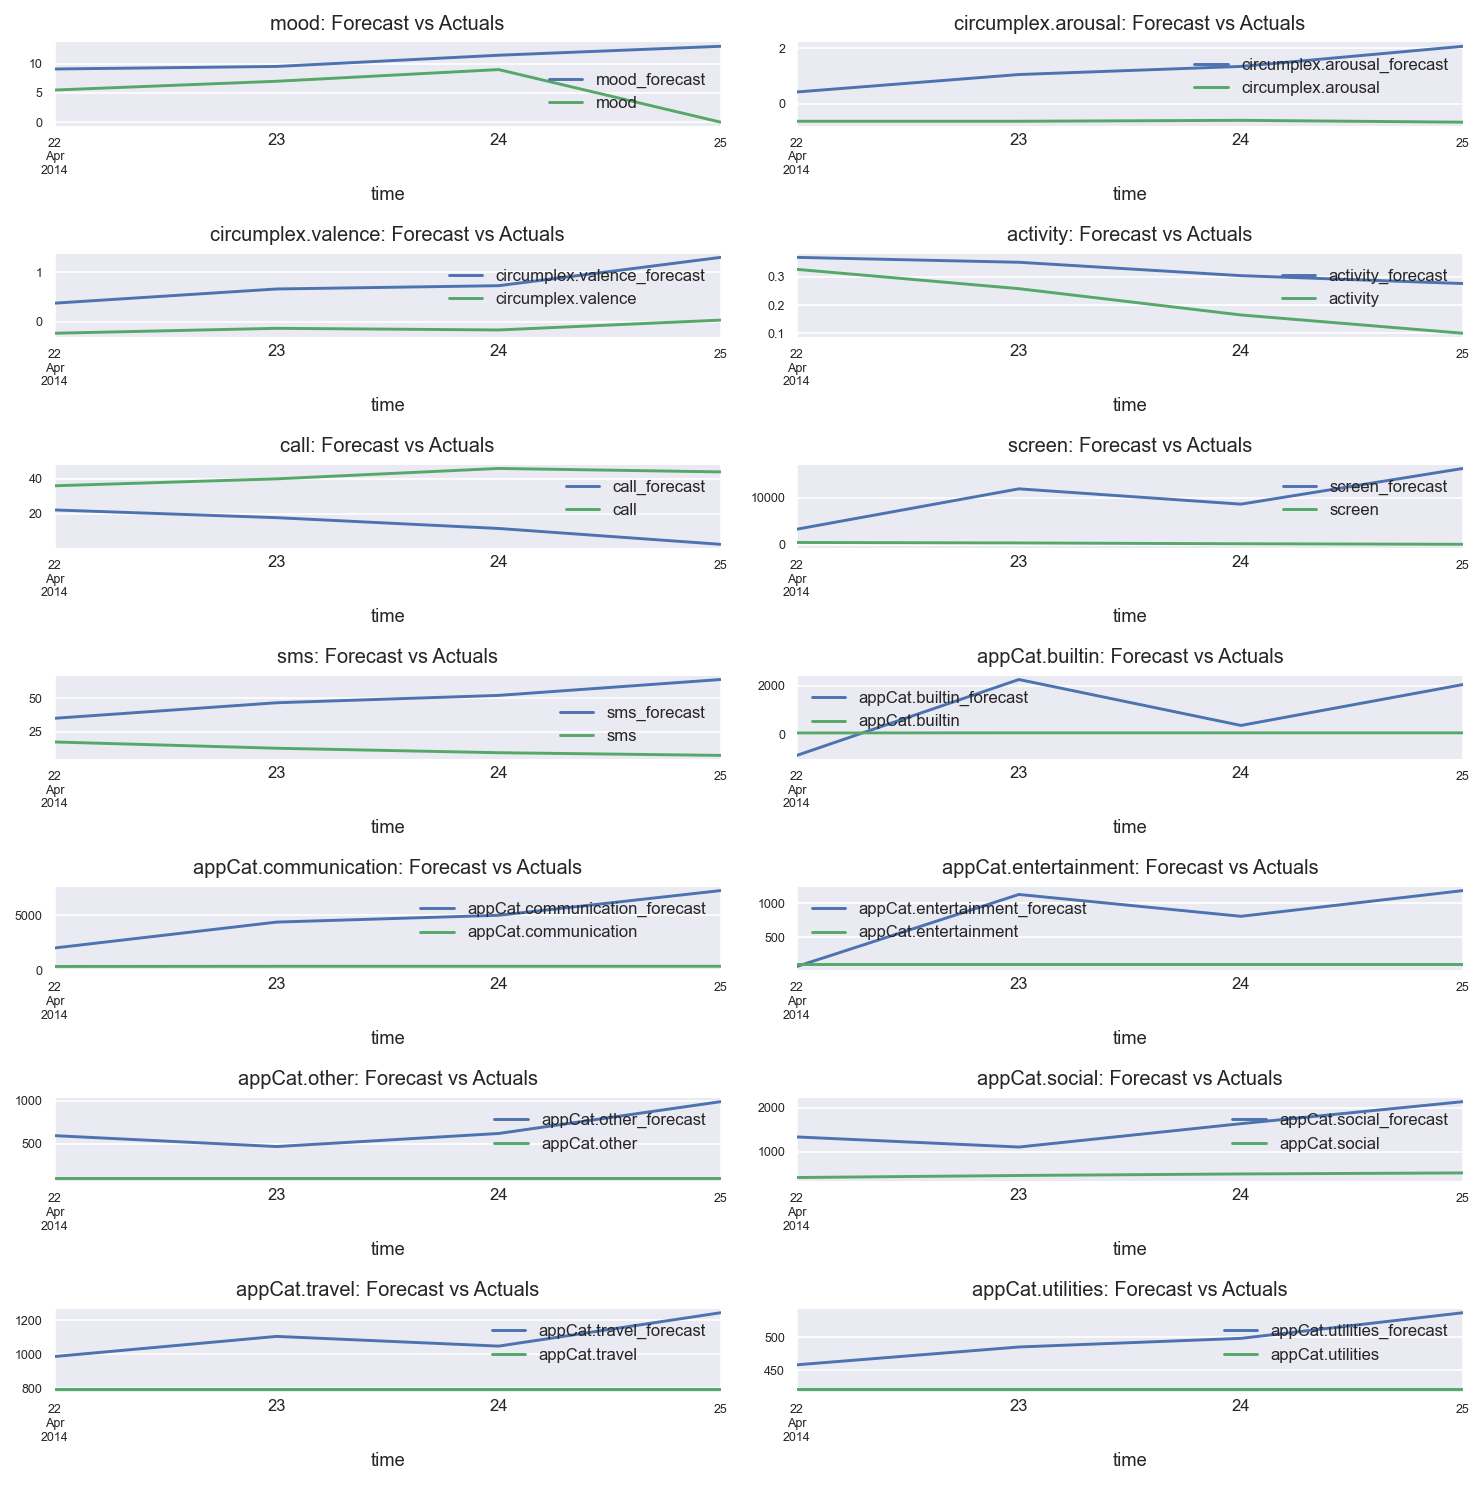

In [264]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### 特征工程模型——决策树回归
#### 1.滚动统计多日数据
通过按日期从大到小对数据集排序，滚动计算出每N天的属性，通过设置滚动窗口windows的值和属性列不同统计方法polymerizations的值，滚动统计函数见roll(df,id,window,polymerizations)，可计算出不同的特征属性数据集，本次计算采用了5日滚动统计，而抑郁患者多日行为对于mood影响力的不同，越靠近预测日的行为对预测日的mood值影响越大，因此采用了自定义的加权平均函数weightedmean，权值为1/sum(1..n)，2/sum(1..n),3/sum(1..n),...计算出最终的属性值，详见函数datatransform

In [100]:
def weightedmean(x):
    '''
    自定义加权平均统计函数,根据预测值与越近的日期的variable影响越大，
    因此加权计算更合理，权值为1/sum(1..n)，2/sum(1..n),3/sum(1..n),...
    '''
    window=len(x)
    weights = np.arange(window,0,-1)
    weights=weights/np.sum(weights)
    # 去除NaN的影响，否则如果x有值NaN，计算结果为NaN
    x[np.isnan(x)] = 0
    weights[np.isnan(x)] = 0
    return np.average(x,axis=0,weights=weights)

def roll(df,id,window,polymerizations):
    '''
    按窗口滚动统计
    
    Args:
        df: dataframe
        id：dataset id
        window: polling window size
        polymerizations：cols 统计规则字典
        
    Returns:
        统计后的dataframe
    '''
    from pandas.api.indexers import FixedForwardWindowIndexer
    
    #从df中取出特定id集
    tmp=df[df['id']==id].copy()
    #设置time列为索引列
    tmp.set_index('time',inplace=True)  

    #取出mood列
    mood=tmp['mood']
    #将索引减去1天，设置前一天预测值
    mood.index=mood.index - datetime.timedelta(days=1)

    #滚动统计后window项各列，作为当前日期的值
    tmp=tmp.rolling(window=FixedForwardWindowIndexer(window_size=window),min_periods=1).agg(polymerizations)
    
    #设置id列
    tmp['id']=id
    #清空mood列，设置mood预测值
    tmp['mood']=np.nan
    tmp['mood']=mood
    
    return tmp

def datatransform(df,polymerizations,window=5):
    '''
    数据集转换，将variable转换为字段

    Args:
        df             ：需转换的dataframe
        polymerizations: 
        window         :滚动统计计算的窗口，缺省为5天
        
    Returns:
        转换后的dataframe
    
    '''
    
    df.reset_index(inplace=True)
    
    # 对数据集按'id','time'排序（降序）
    df.sort_values(by=['id','time'],inplace=True,ascending=False)
    
    # 对值为NaN填入0，否则在滚动计算时，n天中有1天为NaN则计算结果为NaN
    df['activity']=df['activity'].fillna(0)
    #df['circumplex.arousal']=df['circumplex.arousal'].fillna(0)
    df['circumplex.valence']=df['circumplex.valence'].fillna(0)
    #df['call'] = df['call'].apply(lambda x:round(x) if x>0 else 0)
    #df['sms'] = df['sms'].apply(lambda x:round(x) if x>=0 else 0)

    # 取出所有id，并去重
    ids=df['id'].unique()
    frames = []  
    # 按id取出数据进行滚动统计
    for id in ids:
        frame=roll(df,id,window,polymerizations).reset_index()
        frames.append(frame)
    # 将不同id的数据集合并
    newdf=pd.concat(frames,ignore_index=True)
    newdf.set_index(['id','time'],inplace=True)
    return newdf

window=3

colspolymerization={'circumplex.valence':weightedmean,'activity':weightedmean,'call':weightedmean,'screen':weightedmean,
                    'appCat.builtin':weightedmean,'appCat.entertainment':weightedmean,'appCat.finance':weightedmean,
                    'appCat.office':weightedmean,'appCat.other':weightedmean,'appCat.social':weightedmean,'appCat.tools':weightedmean}
#经检验自定义函数数据统计正常，可以使用
colspolymerization1={'mood':'mean','circumplex.valence':'mean','activity':'mean','call':'sum','screen':'sum',
                        'appCat.builtin':'sum','appCat.entertainment':'sum','appCat.finance':'sum',
                        'appCat.office':'sum','appCat.other':'sum','appCat.social':'sum','appCat.tools':'sum'}
polymerizationcols={'mood':'mean','circumplex.arousal':'mean','circumplex.valence':'mean','activity':'mean','call':'sum','screen':'sum',
                        'sms':'sum','appCat.builtin':'sum','appCat.communication':'sum','appCat.entertainment':'sum','appCat.finance':'sum',
                        'appCat.game':'sum','appCat.office':'sum','appCat.other':'sum','appCat.social':'sum','appCat.travel':'sum',
                        'appCat.unknown':'sum','appCat.utilities':'sum','appCat.weather':'sum'}

newdf=datatransform(newdf1d,polymerizationcols,window)
newdf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1323 entries, ('AS14.33', Timestamp('2014-04-15 00:00:00')) to ('AS14.01', Timestamp('2014-05-04 00:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mood                  1295 non-null   float64
 1   circumplex.arousal    1295 non-null   float64
 2   circumplex.valence    1295 non-null   float64
 3   activity              1295 non-null   float64
 4   call                  1262 non-null   float64
 5   screen                1249 non-null   float64
 6   sms                   1246 non-null   float64
 7   appCat.builtin        1249 non-null   float64
 8   appCat.communication  1249 non-null   float64
 9   appCat.entertainment  1210 non-null   float64
 10  appCat.finance        559 non-null    float64
 11  appCat.game           464 non-null    float64
 12  appCat.office         848 non-null    float64
 13  appCat.other          1246 non-null   

#### 2. 进一步数据预处理
数据集：1973行x21列 数据集处理后：358922行x21列
1) 设置id,time为索引列    
2）通过查看数据信息，数据集为1973行，而mood非空行为1245行，对于无mood值的行对预测无意义，因此删除mood为空的行   
3）而对于mood值不为空，其它属性均为空的行对预测无意义，因此删除    
4）call和sms改为列表列  
5）对mood列取整，并转为列表列       
具体处理见函数为datapreprocess2nd

In [347]:
def datapropress2nd(newdf):
    '''
    对转换后的数据进行二次预处理，删除无效列、NaN值、无意义行等
    Args:
        newdf             ：需转换的dataframe
        
    Returns:
        处理后的dataframe

    '''
    #featcols=['circumplex.arousal','circumplex.valence','activity','call','sms','screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
    #             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
    featcols=['circumplex.valence','activity','call','screen','appCat.builtin','appCat.entertainment','appCat.finance',
                 'appCat.office','appCat.other','appCat.social','appCat.tools']
    predictcol='mood'

    tmp=newdf.copy()

    # 设置 'id','time'  为索引列
    #tmp.set_index(['id','time'],inplace=True) 

    # 删除mood列为NaN的行
    tmp.dropna(axis=0,subset =[ "mood"],inplace=True)
    
    # remove attribute value is NaN rows
    tmp=tmp[tmp[featcols].notnull().any(axis=1)] 
    
    # 将call,sms转换为category
    tmp['call'] = tmp['call'].apply(lambda x:round(x) if x>0 else 0)#.astype('category')
    #tmp['sms'] = tmp['sms'].apply(lambda x:round(x) if x>=0 else 0)#.astype('category')
    
    
    # 将mood取整，并转换为category，为分类做准备，如不使用分类模型可不转换
    #tmp['mood']=tmp['mood'].apply(lambda x:round(x)).astype('category')
    #tmp['mood']=tmp['mood'].astype(int)
    tmp['activity']=tmp['activity'].fillna(0)
    #tmp['circumplex.arousal']=tmp['circumplex.arousal'].fillna(0)
    tmp['circumplex.valence']=tmp['circumplex.valence'].fillna(0)
    
    return tmp

newdf1=datapropress2nd(newdf)
savefile='newmooddataset.csv'
newdf1.to_csv(path+savefile)
newdf1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1267 entries, ('AS14.33', Timestamp('2014-04-16 00:00:00')) to ('AS14.01', Timestamp('2014-05-03 00:00:00'))
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mood                  1267 non-null   float64
 1   circumplex.valence    1267 non-null   float64
 2   activity              1267 non-null   float64
 3   call                  1267 non-null   int64  
 4   screen                1221 non-null   float64
 5   appCat.builtin        1221 non-null   float64
 6   appCat.entertainment  1210 non-null   float64
 7   appCat.finance        543 non-null    float64
 8   appCat.office         825 non-null    float64
 9   appCat.other          1220 non-null   float64
 10  appCat.social         1221 non-null   float64
 11  appCat.tools          1169 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 125.4+ KB


## 转换后的dataframe describe

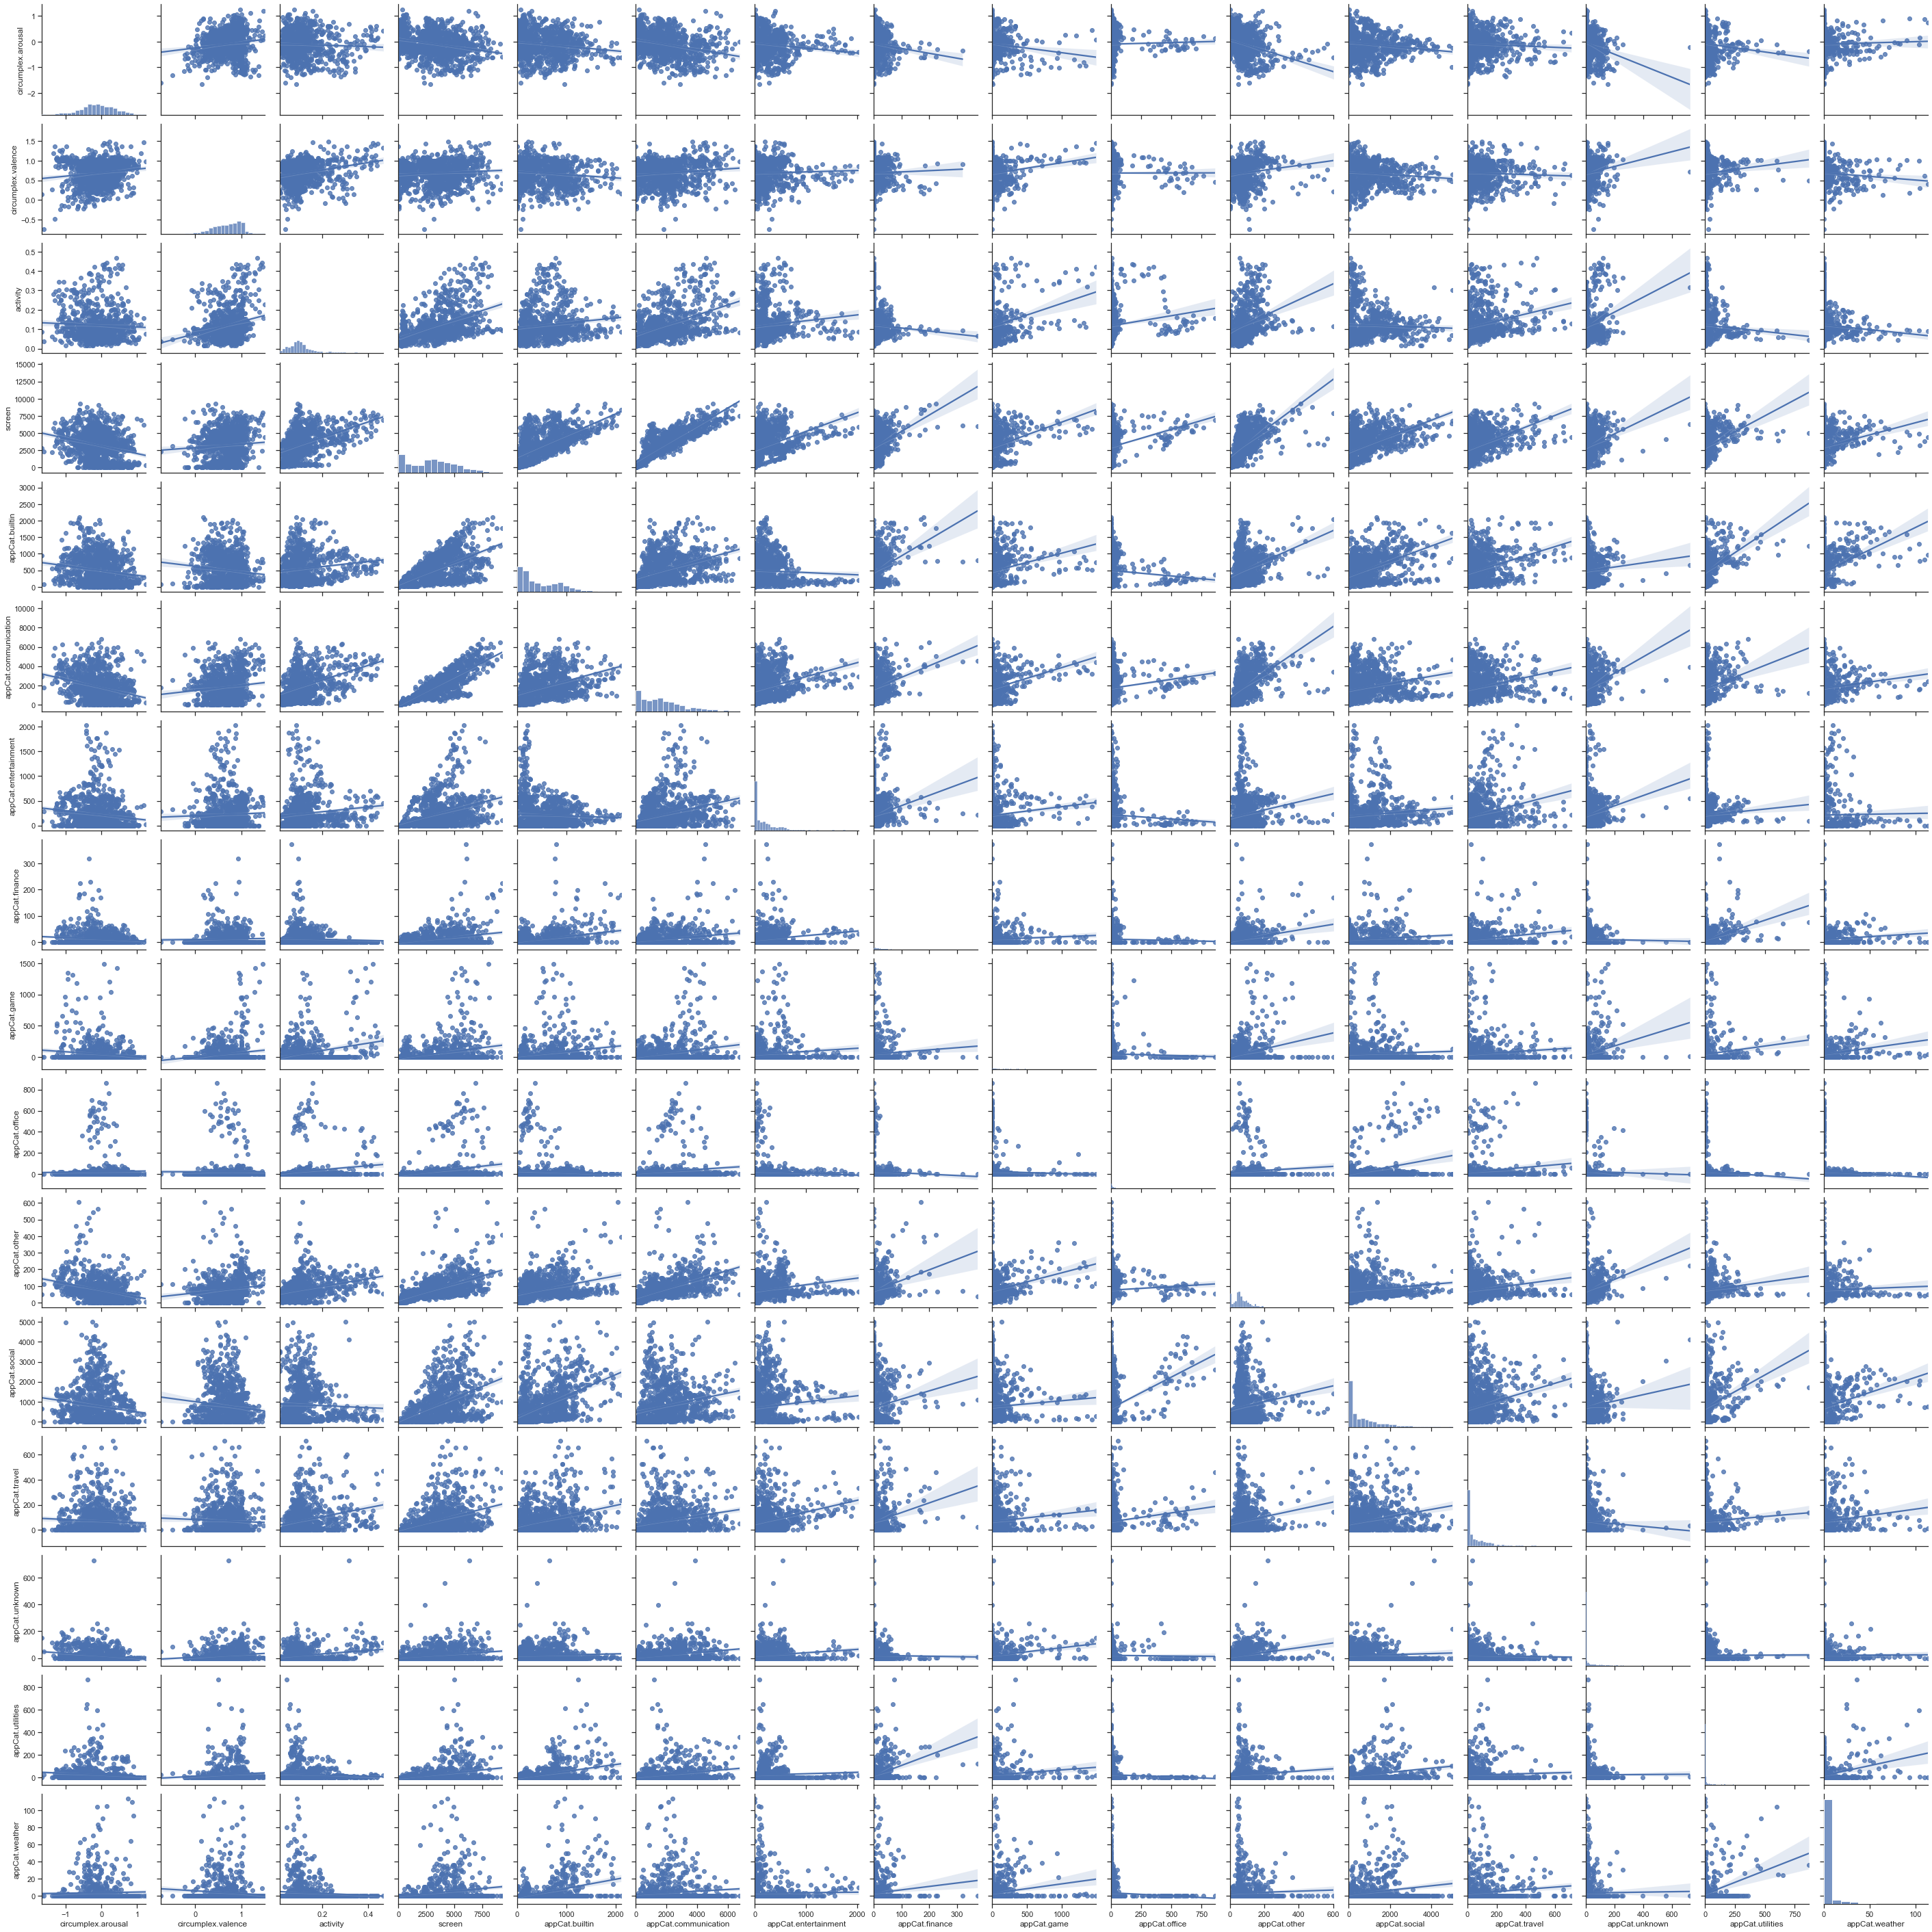

In [36]:
sns.set(style='ticks', color_codes=True)
sns.pairplot(newdf1,kind="reg")

In [349]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import tree #导入需要的模块
import os

#### 3 决策树回归
对mood列不取整   

In [210]:
cols=['activity','circumplex.arousal','circumplex.valence','screen','call','sms','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
        'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']

featcols=['activity','circumplex.arousal','circumplex.valence','screen','call','sms','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
        'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']


train_x,test_x,train_y,test_y=train_test_split(newdf1[featcols],newdf1['mood'],test_size=0.2,random_state=100)

clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(train_x,train_y)#用训练集数据训练模型
pred_y=clf.predict(test_x)
result = clf.score(test_x,test_y)
print(result)
print(*zip(featcols,clf.feature_importances_))


-0.6859314412664381
('activity', 0.0574628785329572) ('circumplex.arousal', 0.13499556442459923) ('circumplex.valence', 0.12836625294332948) ('screen', 0.06784956610917386) ('call', 0.03763235944925738) ('sms', 0.042621945551562415) ('appCat.builtin', 0.052773573913738485) ('appCat.communication', 0.08624166470186553) ('appCat.entertainment', 0.04420009298525405) ('appCat.finance', 0.030917243668113627) ('appCat.game', 0.003920417306166584) ('appCat.office', 0.0629656396399444) ('appCat.other', 0.07501272539340498) ('appCat.social', 0.07621800157622982) ('appCat.travel', 0.02852844677914563) ('appCat.unknown', 0.021162623993363775) ('appCat.utilities', 0.020636685877598888) ('appCat.weather', 0.02849431715429475)


#### 模型评价

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score


RMSE = mean_squared_error(test_y,pred_y)**0.5 
MAE = mean_absolute_error(test_y,pred_y)
R2 = r2_score(test_y,pred_y)
print('RMSE=',RMSE)
print('RMSE=',MAE)
print('R2=',R2)

### 创建benchmark数据集

In [351]:
# Create the temporal dataset and benchmark  dataset
newdf1d2temporal = newdf1d.copy()
newdf1d2benchmark = newdf1d.copy()
newdf1d2temporal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 1294 to 0
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1295 non-null   object        
 1   time                  1295 non-null   datetime64[ns]
 2   mood                  1295 non-null   float64       
 3   circumplex.valence    1295 non-null   float64       
 4   activity              1295 non-null   float64       
 5   call                  1290 non-null   float64       
 6   screen                1249 non-null   float64       
 7   appCat.builtin        1249 non-null   float64       
 8   appCat.entertainment  1238 non-null   float64       
 9   appCat.finance        559 non-null    float64       
 10  appCat.office         848 non-null    float64       
 11  appCat.other          1248 non-null   float64       
 12  appCat.social         1249 non-null   float64       
 13  appCat.tools      

In [352]:
#newdf1d2temporal.reset_index(drop=False,inplace=True)
newdf1d2temporal.set_index(['id','time'],inplace=True)
minmaxscaler = MinMaxScaler()
#create new t column for temporal
for i in ids:
        newdf1d2temporal.loc[i] = minmaxscaler.fit_transform(newdf1d2temporal.loc[i])
        a = newdf1d2temporal.loc[i].index
        for j in np.arange(0,len(a)):
            newdf1d2temporal.loc[i,'t'][a[j]] = j+1

#Add weekend dummy
pd.options.mode.chained_assignment = None
newdf1d2temporal['weekend'] = 0
days = newdf1d2temporal.index.get_level_values(1).weekday
for i in range(len(newdf1d2temporal)):
    if days[i] == 5 or days[i] == 6:
        newdf1d2temporal['weekend'][i] = 1
            
newdf1d2temporal.reset_index(drop=False,inplace=True)
newdf1d2temporal.to_csv('df_temporal.csv')

KeyError: 't'

### benchmark
从github中赋值过来不知道是什么意思？这个均方误差回归损失是如何得来的？

In [344]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

df_bench = newdf1d2benchmark
minmaxscaler = MinMaxScaler()
for i in ids:
    df_bench.loc[i] = minmaxscaler.fit_transform(df_bench.loc[i])
    
df_benchmark = df_bench

df_benchmark['pred'] = np.nan

for i in ids:
        a = df_benchmark.loc[i].index
        for j in np.arange(1,len(a)):
            df_benchmark.loc[i,'pred'][a[j]] = df_benchmark.loc[i,'mood'][a[j-1]]            
            
df_benchmark = df_benchmark[['mood','pred']]
df_benchmark.dropna(inplace=True)

t_test = np.array(df_benchmark['mood'])
t_pred = np.array(df_benchmark['pred'])
MSE=mean_squared_error(t_test,t_pred)
print(MSE)

C:\Users\frank\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\frank\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\frank\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\frank\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\frank\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\frank\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\frank\anaconda3\lib\site-packages\sklearn\preprocessing\_data

0.0693010651876902


<ipython-input-344-fd62bf8dc9b9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_benchmark.dropna(inplace=True)
